<img src="./logo_UTN.svg" align="right" width="150" /> 


<br><br>
#### Procesamiento Digital de Señales

# Trabajo Práctico Nº5
#### Alumno:    Fernando Daniel Fiamberti


##  Filtrado digital lineal de ECG (1ra parte)

# <span style="color:Blue">Enunciado</span>


### Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

    Ruido causado por el movimiento de los electrodos (Alta frecuencia).
    Ruido muscular (Alta frecuencia).
    Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

Ayuda: Los detalles de cómo acceder a ecg.mat los pueden encontrar en lectura_sigs.py
Archivo ECG.mat

(variables)

    ecg_lead: Registro de ECG muestreado a f s igual 1  KHz durante una prueba de esfuerzo
    qrs_pattern1: Complejo de ondas QRS normal
    heartbeat_pattern1: Latido normal
    heartbeat_pattern2: Latido de origen ventricular
    qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos


Se pide:


a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.
Ayuda:  Utilice los resultados del ancho de banda estimado del ECG en la Tarea Semanal anterior. Tome como referencia las siguientes morfologías promedio para evaluar cualitativamente la efectividad de los filtros diseñados.

Plantilla




SinusRhythmLabels.svg
By Created by Agateller (Anthony Atkielski), converted to svg by atom. - SinusRhythmLabels.png, Public Domain, Link
 

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.

Ayuda: Para los filtros IIR adopte las aproximaciones de módulo de máxima planicidad, Chebyshev y Cauer. Para los FIR, utilice las metodologías de ventanas, cuadrados mínimos y Parks-Mc Clellan-Remez. Todos implementados en SciPy.Signal

d)  Evalúe el rendimiento de los filtros que haya diseñado:

    Verifique que filtra las señales interferentes.
    Verifique que es inocuo en las zonas donde no hay interferentes.

Ayuda: Utilice el siguiente código como referencia para analizar los puntos 1 y 2). También puede incluir otras regiones que considere de interés.


Bonus:

    💎 Proponga algún tipo de señal, ya sea de la TS anterior u otra que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.




# Desarrollo de la tarea

### <span style="color:Blue">Código implementado:</span>


# Diseño de los filtros IIR

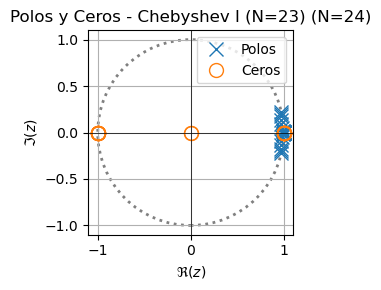

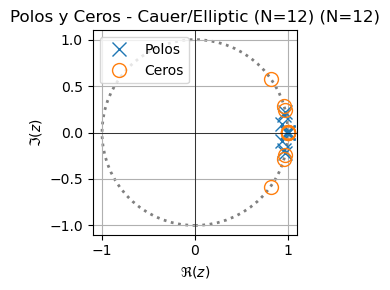

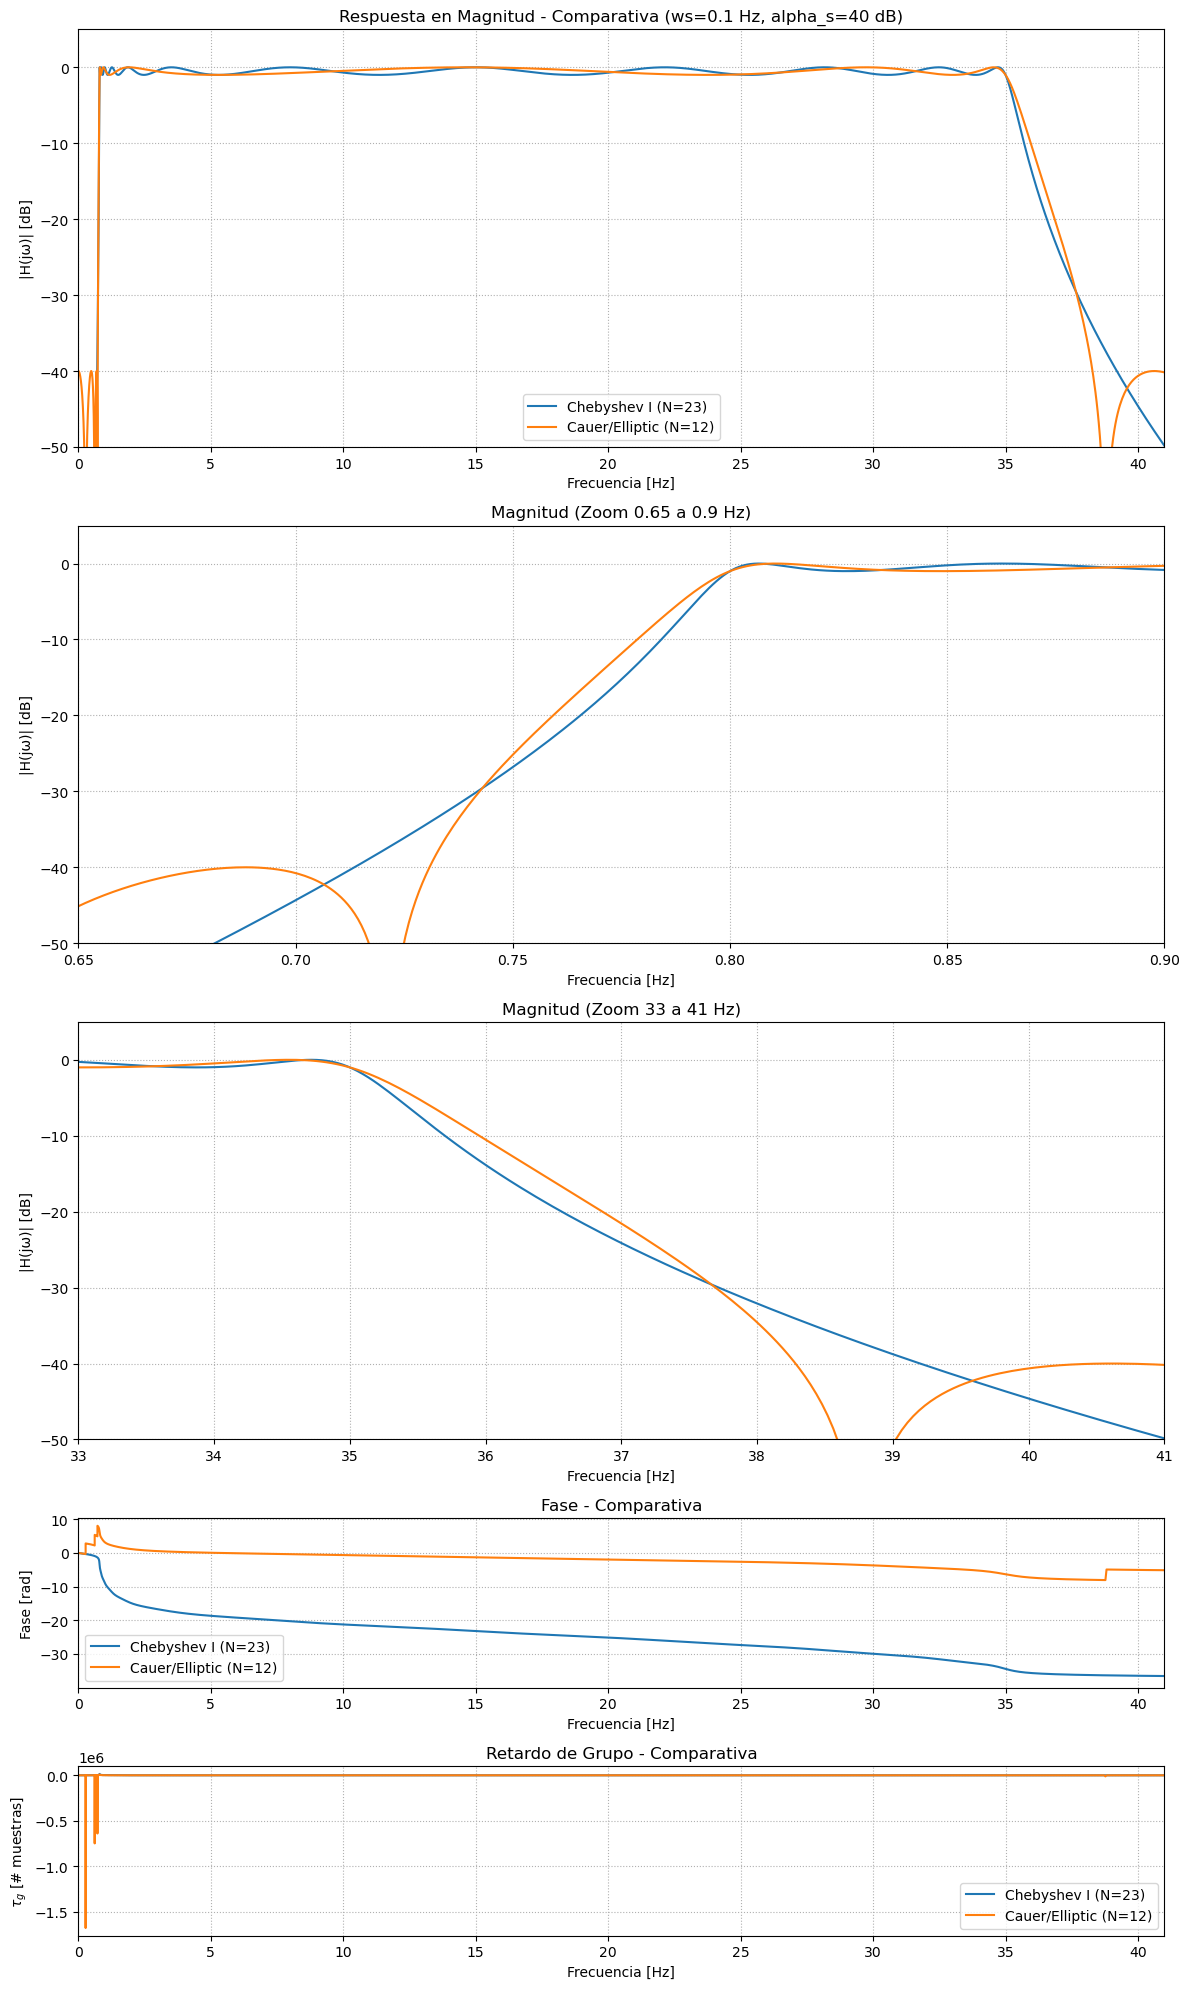

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Diseño de los filtros IIR Chebyshev I y Cauer/Elíptico.

Created on Wed Nov 12 21:48:12 2025

@author: Fernando Daniel Fiamberti
"""

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
from matplotlib import patches
import warnings
import sys
import io

# -------------------------------------------------------------
# 1. Parámetros Generales
# -------------------------------------------------------------
fs = 1000 # Hz

# === ESPECIFICACIONES ===
wp = (0.8, 35) # Frecuencia de corte/paso (Hz)
ws = (0.1, 40) # Frecuencia de stop/detenida (Hz)
alpha_p = 1 # Atenuación máxima en banda de paso (dB)
alpha_s = 40 # Atenuación mínima en banda de atenuación (dB)
# =============================================================

filtros = {}

# -------------------------------------------------------------
# 2. Diseño de los Filtros
# -------------------------------------------------------------

falso_stderr = io.StringIO()

old_stderr = sys.stderr

try:
    sys.stderr = falso_stderr
    N_butt, wn_butt = sig.buttord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
    mi_sos_butt = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='butter', output='sos', fs=fs)
finally:
    sys.stderr = old_stderr
filtros['Butterworth (N=76)'] = mi_sos_butt


# --- Diseño Chebyshev Tipo I (N ~23) ---
N_cheb1, wn_cheb1 = sig.cheb1ord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
mi_sos_cheb1 = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='cheby1', output='sos', fs=fs)
filtros['Chebyshev I (N=23)'] = mi_sos_cheb1


# --- Diseño Chebyshev Tipo II (N ~23) ---
N_cheb2, wn_cheb2 = sig.cheb2ord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
mi_sos_cheb2 = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='cheby2', output='sos', fs=fs)
filtros['Chebyshev II (N=23)'] = mi_sos_cheb2


# --- Diseño Cauer/Elíptico (Estable, N=12) ---
N_cauer, wn_cauer = sig.ellipord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
mi_sos_cauer = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='ellip', output='sos', fs=fs)
filtros['Cauer/Elliptic (N=12)'] = mi_sos_cauer

# -------------------------------------------------------------
# 3. FILTRADO: Seleccionar solo Chebyshev I y Cauer/Elliptic
# -------------------------------------------------------------
filtros_a_mostrar = ['Chebyshev I (N=23)', 'Cauer/Elliptic (N=12)']

# -------------------------------------------------------------
# 4. Análisis de Respuesta y Polos/Ceros (Solo filtros seleccionados)
# -------------------------------------------------------------
resultados = {}

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=sig.BadCoefficients) # Ignorar advertencias específicas de SciPy

    for name, mi_sos in filtros.items():
        if name not in filtros_a_mostrar:
            continue # Ignorar los filtros no seleccionados
        
        # --- Respuesta en frecuencia ---
        w, h = sig.sosfreqz(mi_sos, worN=np.logspace(np.log10(0.01), np.log10(fs/2), 10000), fs = fs)

        # --- Cálculo de fase y retardo de grupo ---
        phase = np.unwrap(np.angle(h))
        w_rad = w / (fs/2) * np.pi
        gd = -np.diff(phase) / np.diff(w_rad)

        # --- Polos y ceros ---
        z, p, k = sig.sos2zpk(mi_sos)
        order = mi_sos.shape[0] * 2
        

        resultados[name] = {'w': w, 'h': h, 'phase': phase, 'gd': gd, 'z': z, 'p': p, 'order': order}

        # Diagrama de polos y ceros individual
        plt.figure(figsize=(3,3)) 
        plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Polos' )
        if len(z) > 0:
            plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Ceros')
        
        axes_hdl = plt.gca()
        unit_circle = patches.Circle((0, 0), radius=1, fill=False, color='gray', ls='dotted', lw=2)
        axes_hdl.add_patch(unit_circle)

        plt.axhline(0, color='k', lw=0.5)
        plt.axvline(0, color='k', lw=0.5)
        plt.axis([-1.1, 1.1, -1.1, 1.1])
        plt.title(f'Polos y Ceros - {name} (N={order})')
        plt.xlabel(r'$\Re(z)$')
        plt.ylabel(r'$\Im(z)$')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()


# ----------------------------------------------------------------------------------------
# 5. Gráficas Comparativas (Magnitud, Fase, Retardo de Grupo - Solo los seleccionados)
# ----------------------------------------------------------------------------------------

fig = plt.figure(figsize=(12, 20)) # Altura ajustada para 8 unidades de cuadrícula
gs = fig.add_gridspec(8, 1) # 8 filas (2+2+2+1+1)

eps = 1e-8 # Piso numérico para evitar log10(0)

# 1. Magnitud General (Doble de altura: filas 0 y 1)
ax1 = fig.add_subplot(gs[0:2, 0])
for name, res in resultados.items():
    ax1.plot(res['w'], 20*np.log10(abs(res['h']) + eps), label = name)
ax1.set_title(f'Respuesta en Magnitud - Comparativa (ws={ws[0]} Hz, alpha_s={alpha_s} dB)')
ax1.set_xlabel('Frecuencia [Hz]')
ax1.set_ylabel('|H(jω)| [dB]')
ax1.set_ylim([-50, 5]) 
ax1.set_xlim([0, 41]) # Limita la vista del eje X de 0 a 41 Hz
ax1.grid(True, which='both', ls=':')
ax1.legend()
 
# 2. Magnitud Zoom 0.65 a 0.9 Hz 
ax2 = fig.add_subplot(gs[2:4, 0])
for name, res in resultados.items():
    ax2.plot(res['w'], 20*np.log10(abs(res['h']) + eps), label = name)
ax2.set_title('Magnitud (Zoom 0.65 a 0.9 Hz)')
ax2.set_xlabel('Frecuencia [Hz]')
ax2.set_ylabel('|H(jω)| [dB]')
ax2.set_ylim([-50, 5])
ax2.set_xlim([0.65, 0.9]) # Limita a 0.65-0.9 Hz
ax2.grid(True, which='both', ls=':')

# 3. Magnitud Zoom 33 a 41 Hz 
ax3 = fig.add_subplot(gs[4:6, 0])
for name, res in resultados.items():
    ax3.plot(res['w'], 20*np.log10(abs(res['h']) + eps), label = name)
ax3.set_title('Magnitud (Zoom 33 a 41 Hz)')
ax3.set_xlabel('Frecuencia [Hz]')
ax3.set_ylabel('|H(jω)| [dB]')
ax3.set_ylim([-50, 5])
ax3.set_xlim([33, 41]) # Limita a 33-41 Hz
ax3.grid(True, which='both', ls=':')


# 4. Fase 
ax4 = fig.add_subplot(gs[6, 0])
for name, res in resultados.items():
    ax4.plot(res['w'], res['phase'], label = name)
ax4.set_title('Fase - Comparativa')
ax4.set_xlabel('Frecuencia [Hz]')
ax4.set_ylabel('Fase [rad]')
ax4.set_xlim([0, 41]) # <--- MODIFICACIÓN APLICADA: Límite del eje X
ax4.grid(True, which='both', ls=':')
ax4.legend()

# 5. Retardo de grupo 
ax5 = fig.add_subplot(gs[7, 0])
for name, res in resultados.items():
    ax5.plot(res['w'][:-1], res['gd'], label = name) 
ax5.set_title('Retardo de Grupo - Comparativa')
ax5.set_xlabel('Frecuencia [Hz]')
ax5.set_ylabel(r'$\tau_g$ [# muestras]')
ax5.set_xlim([0, 41]) # <--- MODIFICACIÓN APLICADA: Límite del eje X
ax5.grid(True, which='both', ls=':')
ax5.legend()


plt.tight_layout()
plt.show() # Única llamada a show() para mostrar todas las figuras pendientes.

# Diseño de los filtros FIR

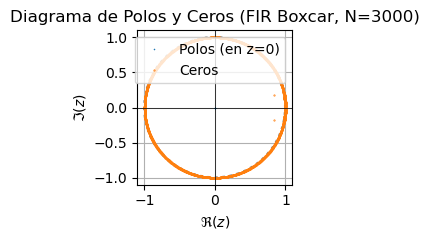

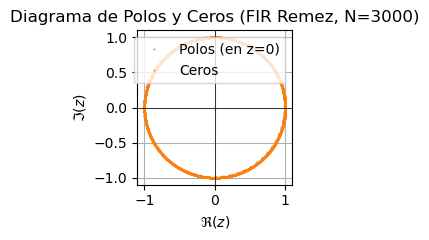

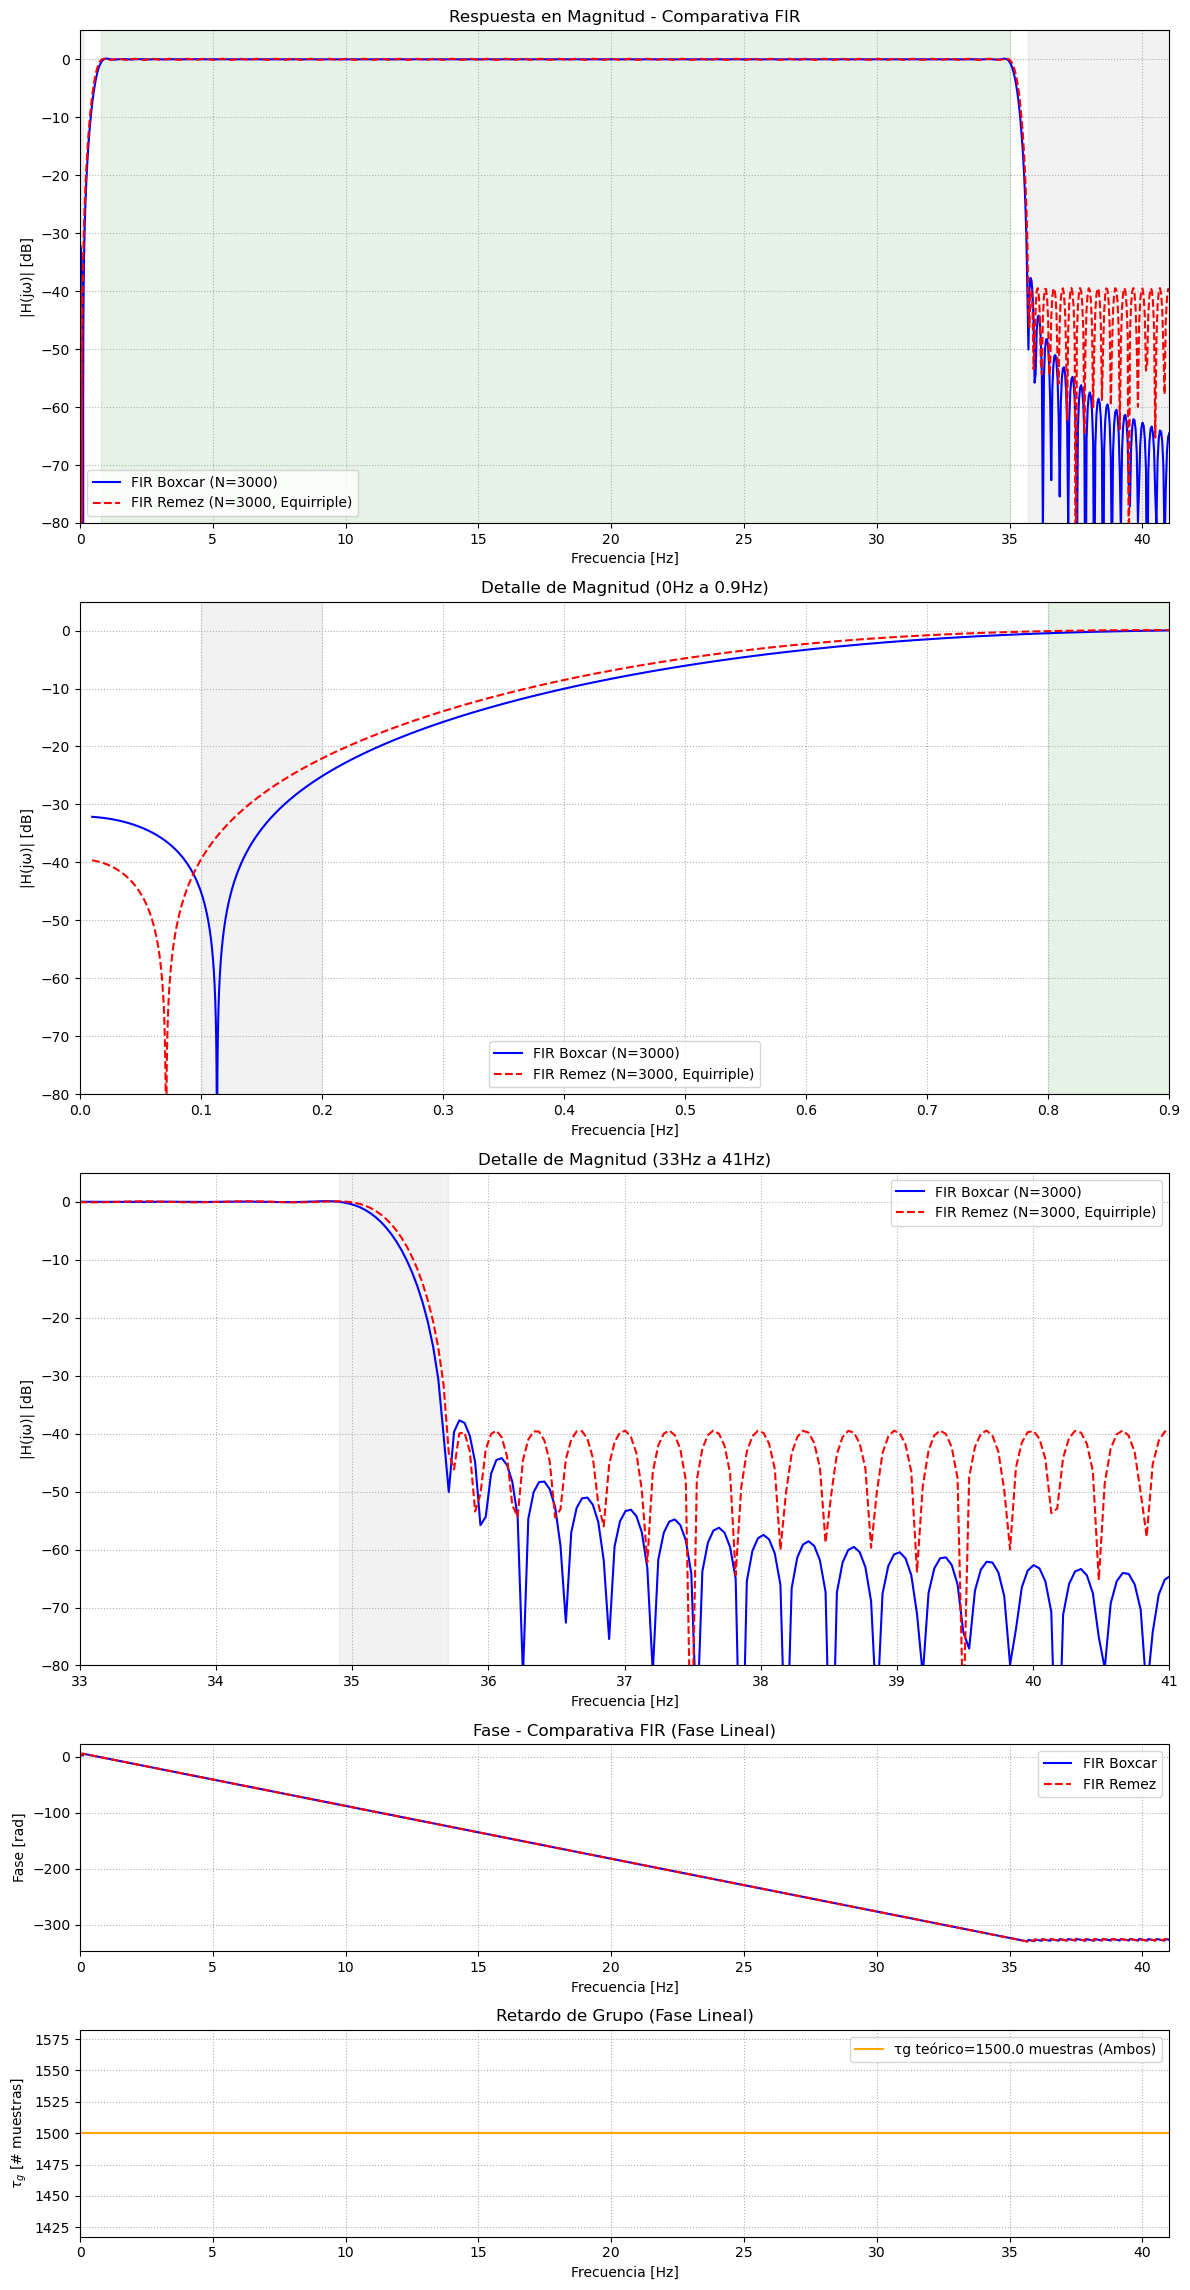

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Diseño de dos filtros FIR: Ventana Rectangular (Boxcar) y Remez/Parks-McClellan.

Created on Wed Nov 12 21:57:34 2025

@author: Fernando Daniel Fiamberti
"""

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
from matplotlib import patches
import sys

# --- Parámetros Generales ---
fs = 1000 # Hz (Frecuencia de muestreo)
N = 3000    # Orden del filtro (Número de coeficientes - 1)
numtaps = N + 1 # Número de coeficientes/taps

wp = (0.8 , 35 )    # Frecuencia de corte/paso (Hz)
#-----------------------------
# PREDISTORSION
#-----------------------------
delta0 = 0
delta1 = 0.1

ws0 = 0.1  
ws1 = 35.7    

ws = (ws0, ws1 )    # Frecuencia de stop/detenida (Hz)
#-----------------------------


# -------------------------------------------------------------
# 1. Definición de la Plantilla y Bandas (Común a ambos filtros)
# -------------------------------------------------------------
# Plantilla de sig.firwin2 (solo se usa para Boxcar)
f_deseada = [
    0,              
    ws[0] + delta1,     
    wp[0],          
    wp[1],          
    ws[1] - delta1,     
    fs / 2          
]

m_deseada = [
    0, 0, 1, 1, 0, 0
]

# Bandas para sig.remez (necesita las frecuencias de transición en pares)
# El diseño remez usa la frecuencia normalizada (0 a fs/2), pero podemos usar fs=fs
f_remez = [0, ws[0], wp[0], wp[1], ws[1], fs/2]

# Magnitudes deseadas para remez (Bandas de detención 0, Banda de paso 1)
a_remez = [0, 1, 0]  


# -------------------------------------------------------------
# 2. Diseño del Filtro FIR 1 (Ventana Rectangular -> Boxcar)
# -------------------------------------------------------------
# b_boxcar es el arreglo de coeficientes
b_boxcar = sig.firwin2(numtaps=numtaps, freq=f_deseada, gain=m_deseada, fs=fs, window='boxcar')

# --- Respuesta en frecuencia (Boxcar) ---
w, H_boxcar = sig.freqz(b_boxcar, a=1, worN=np.logspace(-2,np.log10(fs/2),10000), fs=fs)

# --- Cálculo de fase y retardo de grupo (Boxcar) ---
phase_boxcar = np.unwrap(np.angle(H_boxcar))
gd_esperado = N / 2  
w_rad = w / (fs/2) * np.pi
gd_boxcar = -np.diff(phase_boxcar) / np.diff(w_rad)

# --- Polos y ceros (Boxcar) ---
z_boxcar = np.roots(b_boxcar)
p_boxcar = np.zeros(N)


# -------------------------------------------------------------
# 3. Diseño del Filtro FIR 2 (Remez/Parks-McClellan)
# -------------------------------------------------------------
# El diseño Remez utiliza el algoritmo equirriple, que optimiza el rizado.
# Nota: La función remez espera las bandas en pares [banda_detencion, banda_paso, banda_detencion...]
b_remez = sig.remez(numtaps=numtaps, bands=f_remez, desired=a_remez, fs=fs, type='bandpass')

# --- Respuesta en frecuencia (Remez) ---
w_r, H_remez = sig.freqz(b_remez, a=1, worN=np.logspace(-2,np.log10(fs/2),10000), fs=fs)

# --- Cálculo de fase y retardo de grupo (Remez) ---
phase_remez = np.unwrap(np.angle(H_remez))
gd_remez = -np.diff(phase_remez) / np.diff(w_rad)  

# --- Polos y ceros (Remez) ---
z_remez = np.roots(b_remez)
p_remez = np.zeros(N)


# -------------------------------------------------------------
# 4. Diagramas de Polos y Ceros
# -------------------------------------------------------------

# --- Función auxiliar para graficar Polos/Ceros ---
def plot_pz(z, p, title, order):
    plt.figure(figsize=(2.5,2.5))  # Tamaño de figura reducido a la mitad (2.5, 2.5)
    plt.plot(np.real(p), np.imag(p), 'x', markersize=0.5, label='Polos (en z=0)' )  
    axes_hdl = plt.gca()
    if len(z) > 0:
        plt.plot(np.real(z), np.imag(z), 'o', markersize=0.5, fillstyle='none', label='Ceros')  
    plt.axhline(0, color='k', lw=0.5)
    plt.axvline(0, color='k', lw=0.5)
    unit_circle = patches.Circle((0, 0), radius=1, fill=False, color='gray', ls='dotted', lw=2)
    axes_hdl.add_patch(unit_circle)
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    plt.title(f'Diagrama de Polos y Ceros ({title}, N={order})')
    plt.xlabel(r'$\Re(z)$')
    plt.ylabel(r'$\Im(z)$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pz(z_boxcar, p_boxcar, 'FIR Boxcar', N)
plot_pz(z_remez, p_remez, 'FIR Remez', N)


# -------------------------------------------------------------
# 5. Gráficas Comparativas
# -------------------------------------------------------------
plt.figure(figsize=(12,23)) 

eps = 1e-8  

# Magnitud Principal (ahora ocupa 2 filas)
plt.subplot(8,1,(1,2)) 
plt.plot(w, 20*np.log10(abs(H_boxcar) + eps), label = f'FIR Boxcar (N={N})', color='blue')
plt.plot(w_r, 20*np.log10(abs(H_remez) + eps), label = f'FIR Remez (N={N}, Equirriple)', color='red', linestyle='--')
plt.title('Respuesta en Magnitud - Comparativa FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')

# Dibujar las bandas requeridas (Regiones de la plantilla)
plt.axvspan(0, ws[0], color='gray', alpha=0.1)      
plt.axvspan(wp[0], wp[1], color='green', alpha=0.1)
plt.axvspan(ws[1], fs/2, color='gray', alpha=0.1)    

plt.ylim([-80, 5])  
plt.xlim([0, 41])  

plt.grid(True, which='both', ls=':')
plt.legend()

# Detalle de 0.65Hz a 0.9Hz
plt.subplot(8,1,(3,4)) 
plt.plot(w, 20*np.log10(abs(H_boxcar) + eps), label = f'FIR Boxcar (N={N})', color='blue')
plt.plot(w_r, 20*np.log10(abs(H_remez) + eps), label = f'FIR Remez (N={N}, Equirriple)', color='red', linestyle='--')
plt.title('Detalle de Magnitud (0Hz a 0.9Hz)') # Título actualizado
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.xlim([0, 0.9]) # Rango específico de 0Hz a 0.9Hz
plt.ylim([-80, 5]) 
plt.axvspan(ws[0], ws[0] + delta1, color='gray', alpha=0.1) # Resaltar transición
plt.axvspan(wp[0], wp[1], color='green', alpha=0.1) # Resaltar banda de paso
plt.grid(True, which='both', ls=':')
plt.legend()


# Detalle de 33Hz a 41Hz
plt.subplot(8,1,(5,6)) 
plt.plot(w, 20*np.log10(abs(H_boxcar) + eps), label = f'FIR Boxcar (N={N})', color='blue')
plt.plot(w_r, 20*np.log10(abs(H_remez) + eps), label = f'FIR Remez (N={N}, Equirriple)', color='red', linestyle='--')
plt.title('Detalle de Magnitud (33Hz a 41Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.xlim([33, 41]) # Rango específico
plt.ylim([-80, 5]) #
plt.axvspan(wp[1] - delta1, ws[1], color='gray', alpha=0.1) # Resaltar transición
plt.grid(True, which='both', ls=':')
plt.legend()

 
# Fase 
plt.subplot(8,1,7) 
plt.plot(w, phase_boxcar, label = 'FIR Boxcar', color='blue')
plt.plot(w_r, phase_remez, label = 'FIR Remez', color='red', linestyle='--')
plt.title('Fase - Comparativa FIR (Fase Lineal)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.xlim([0, 41]) 
plt.grid(True, which='both', ls=':')
plt.legend()


# Retardo de grupo 
plt.subplot(8,1,8) 
# El retardo de grupo es el mismo N/2 para ambos filtros de fase lineal
plt.axhline(gd_esperado, color='orange', linestyle='-', label=f'τg teórico={gd_esperado:.1f} muestras (Ambos)')
plt.title('Retardo de Grupo (Fase Lineal)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel(r'$\tau_g$ [# muestras]')
plt.xlim([0, 41]) 
plt.grid(True, which='both', ls=':')
plt.legend()


plt.tight_layout()
plt.show()

# Señal ECG original y filtrada
## Comparación de los cuatro filtros diseñados

Cargando ecg.mat...
Cargadas 1120000 muestras de ECG con ruido.
Aplicando filtro: FIR Boxcar...
Aplicando filtro: FIR Parks-McClellan...
Aplicando filtro: IIR Chebyshev I...
Aplicando filtro: IIR Cauer/Elíptico...

--- Filtrado Completado para los 4 Diseños. ---

--- Generando Gráficos de Verificación de Respuesta en Frecuencia (Punto c) ---


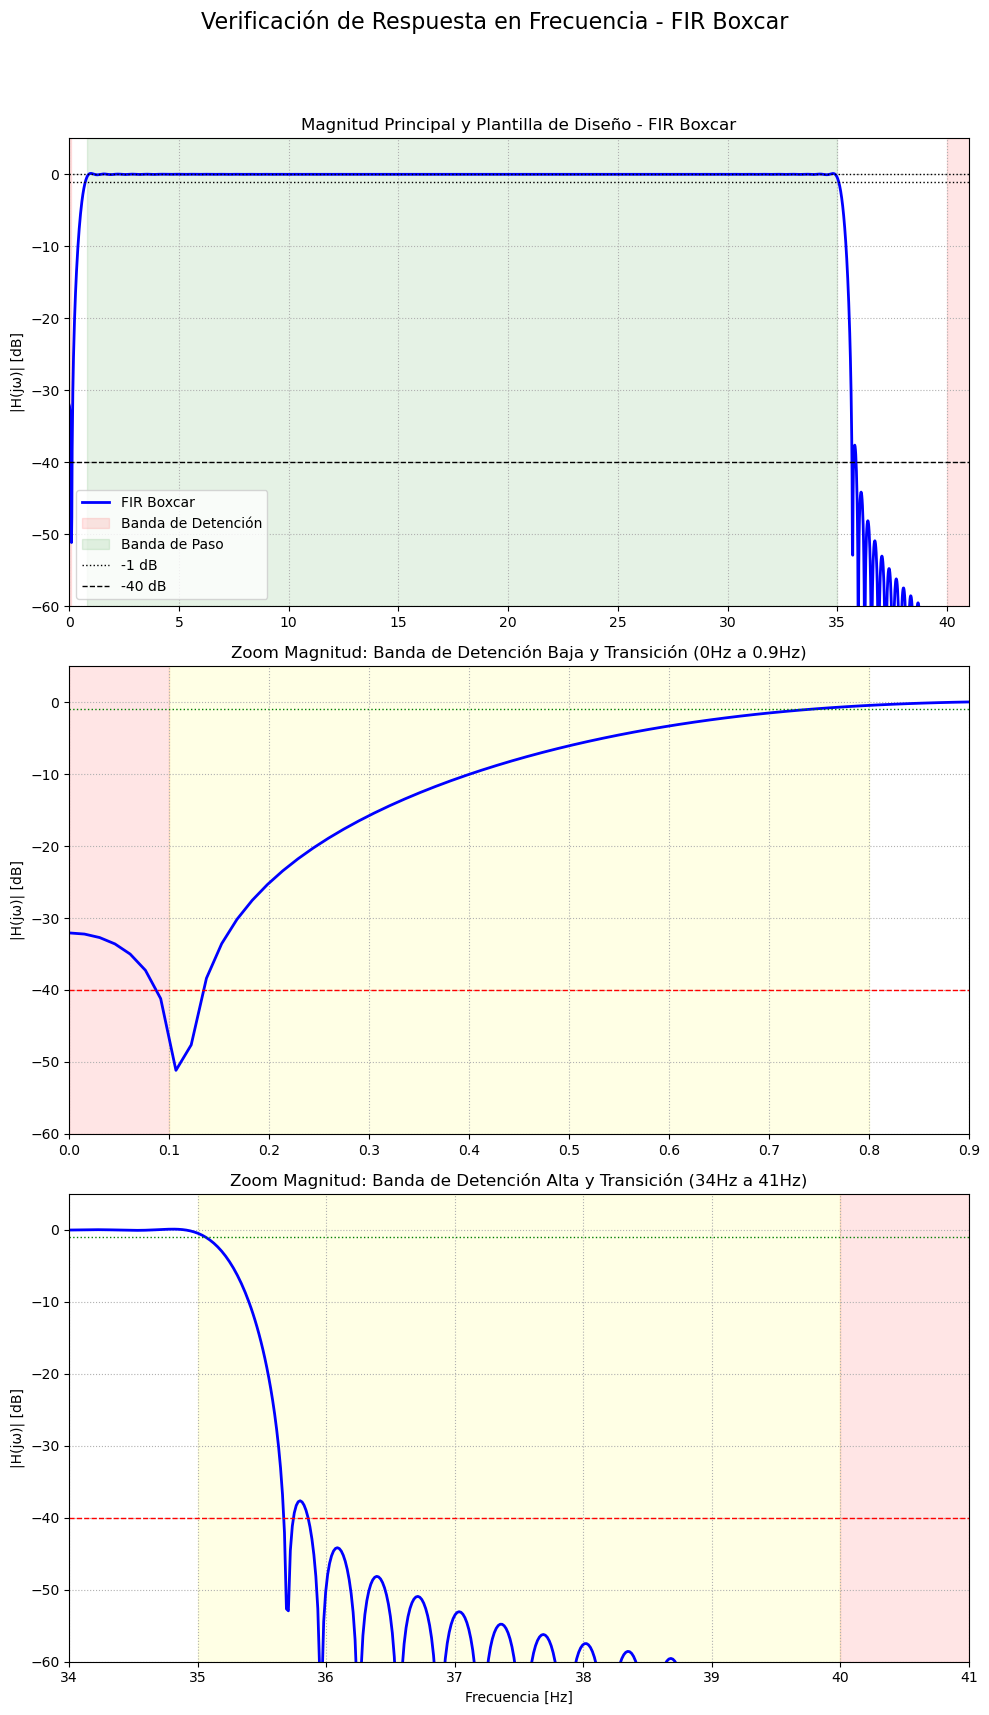

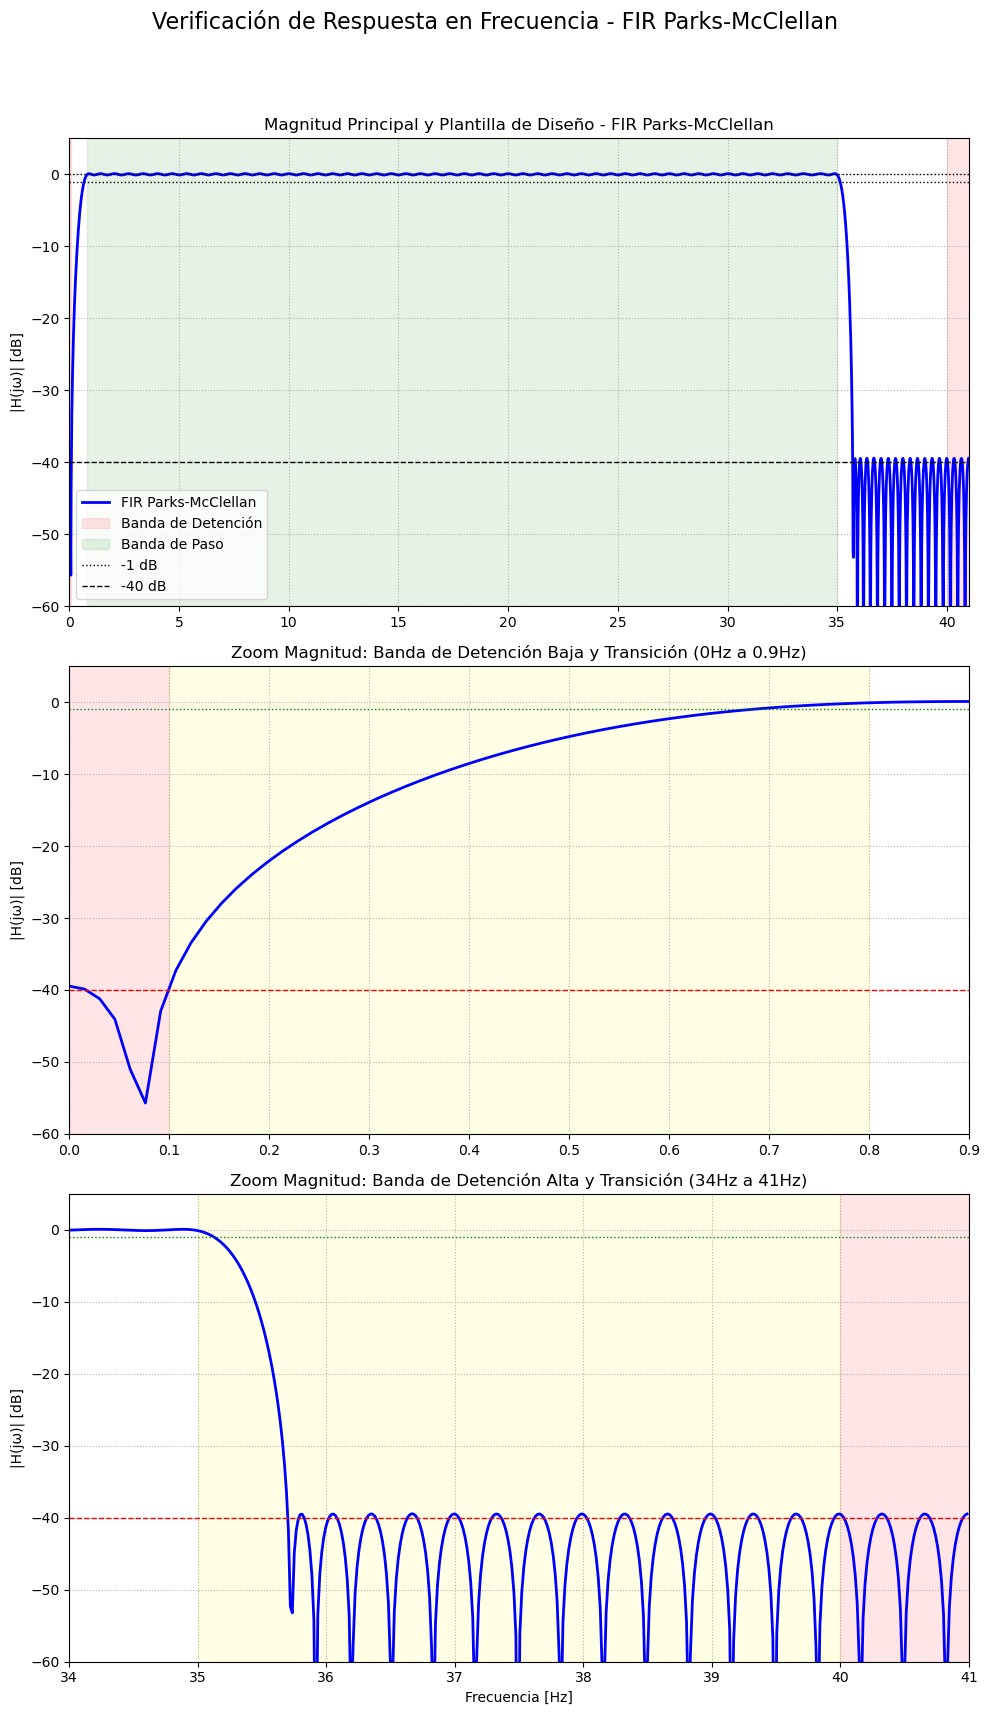

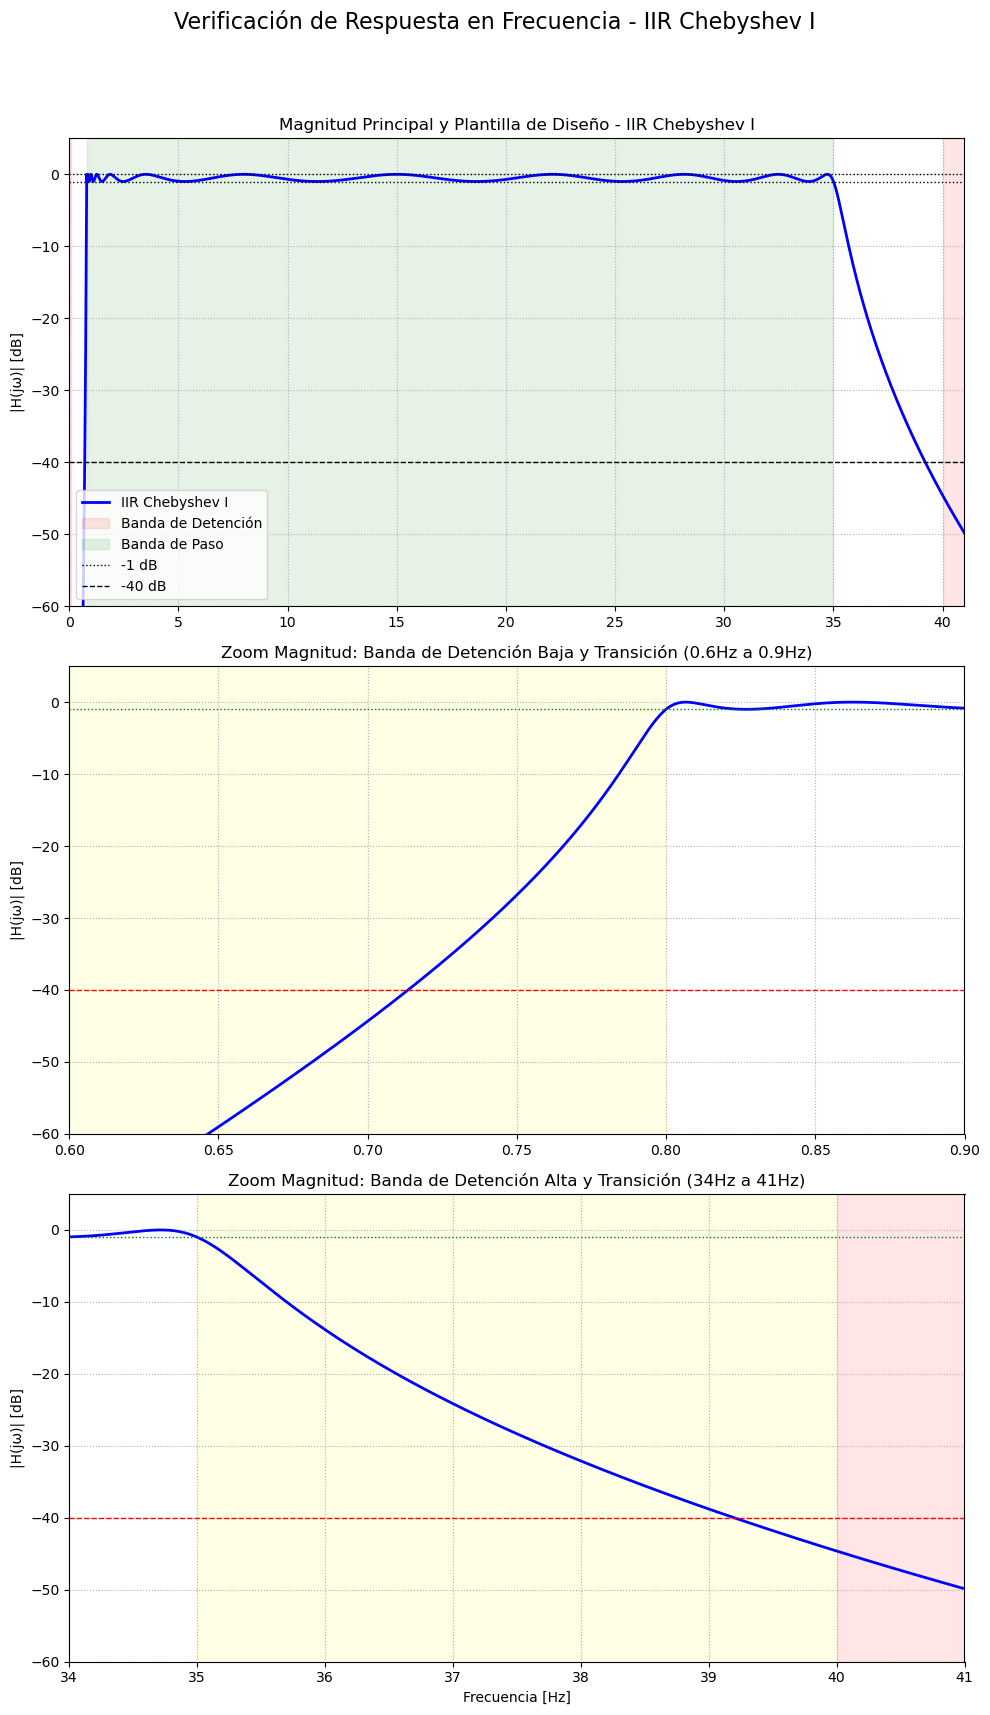

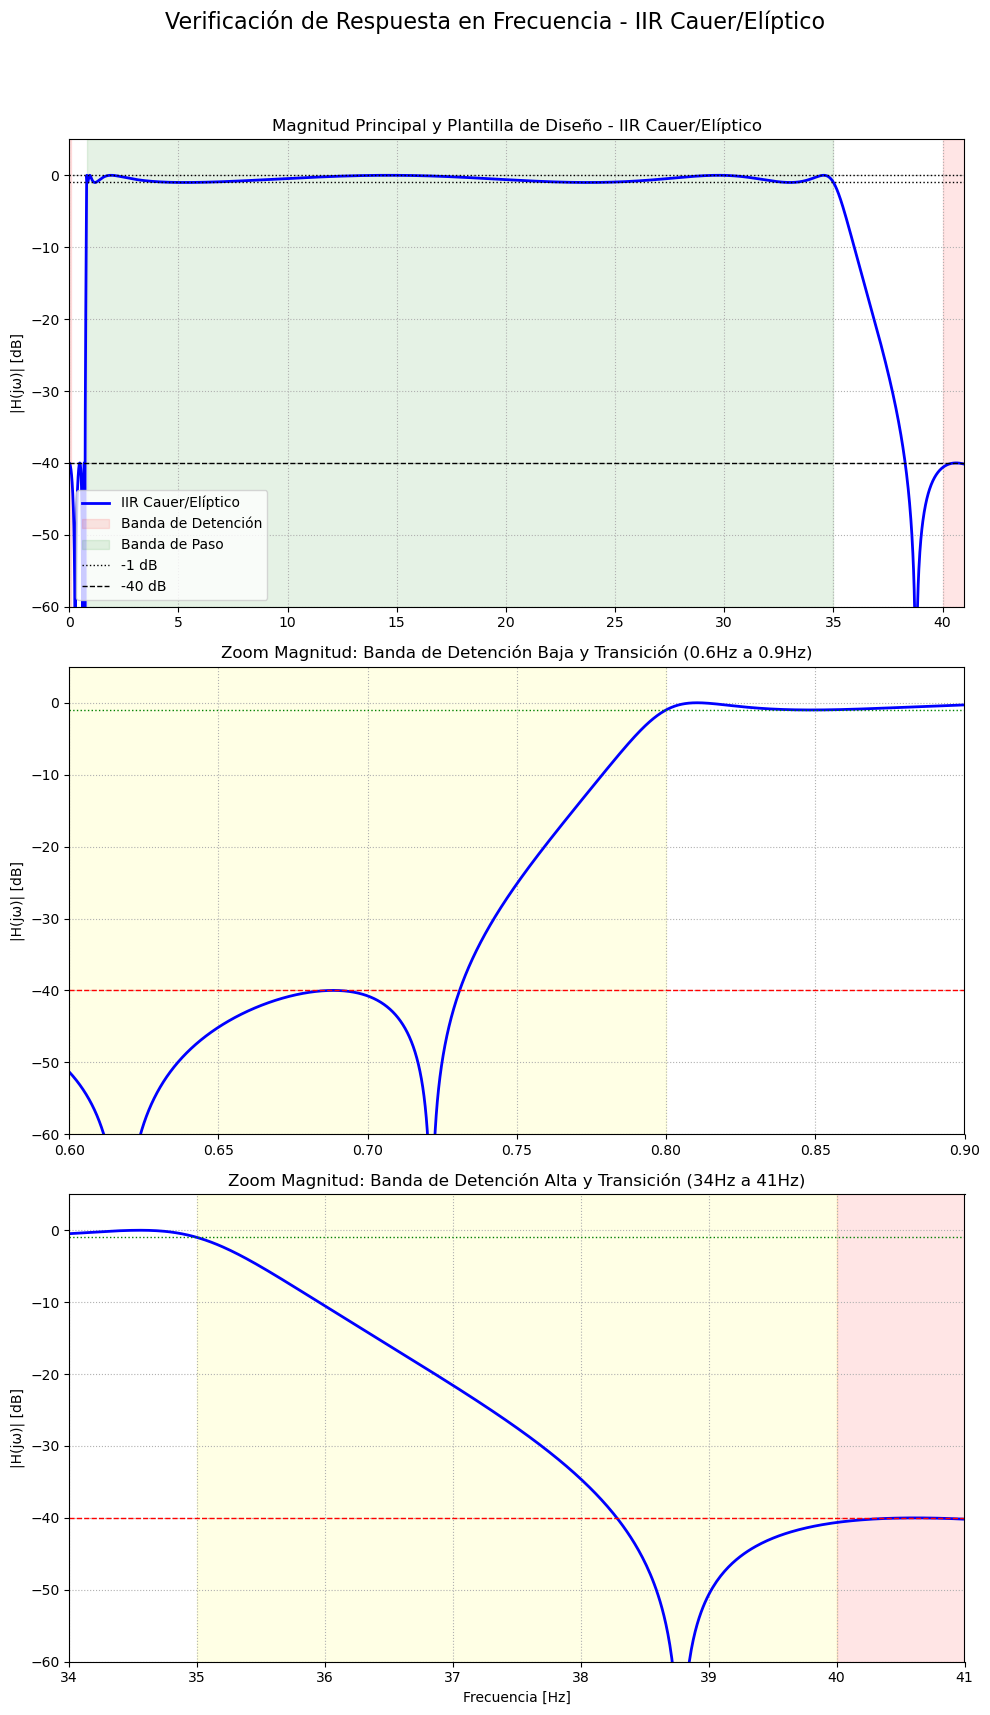

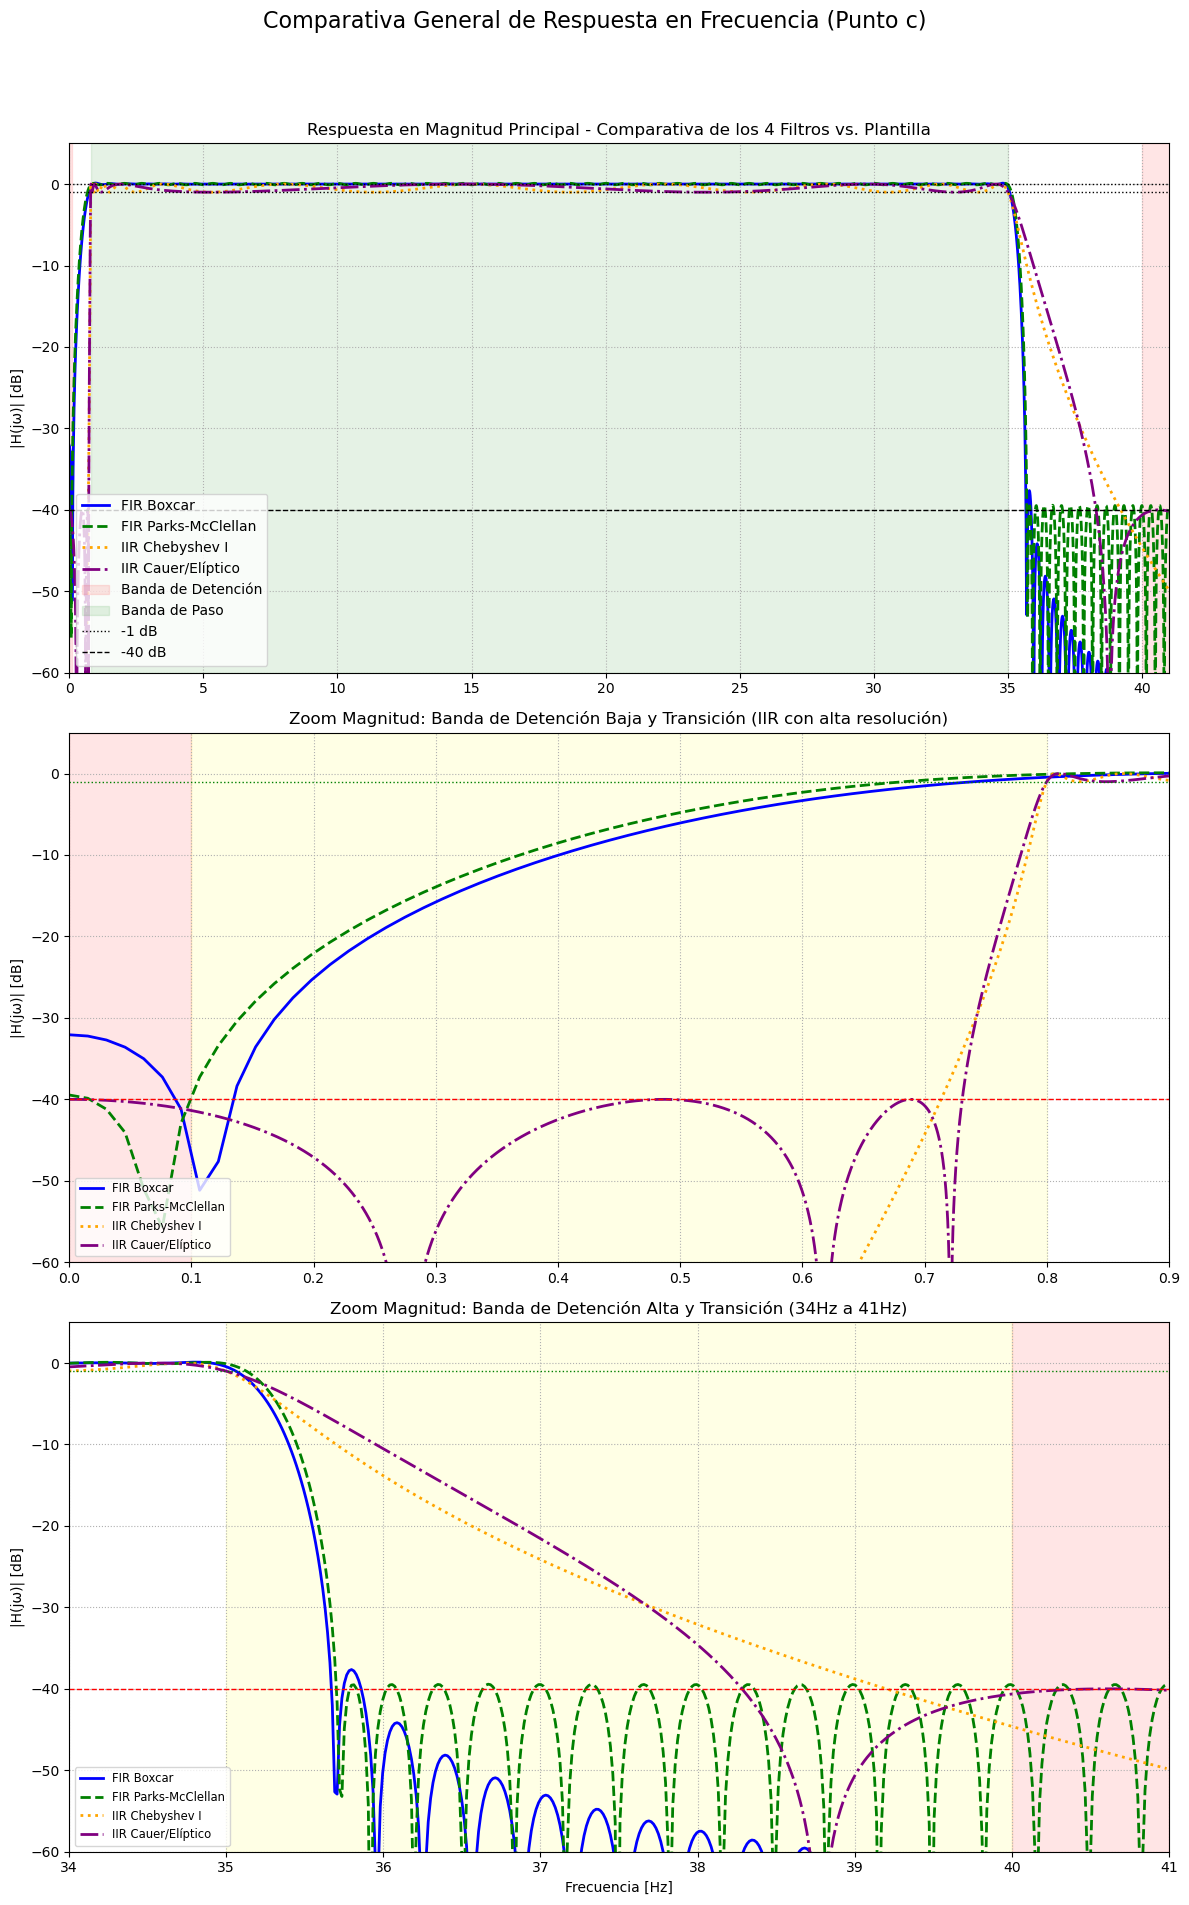


--- Generando 13 Gráficos de Zoom ---


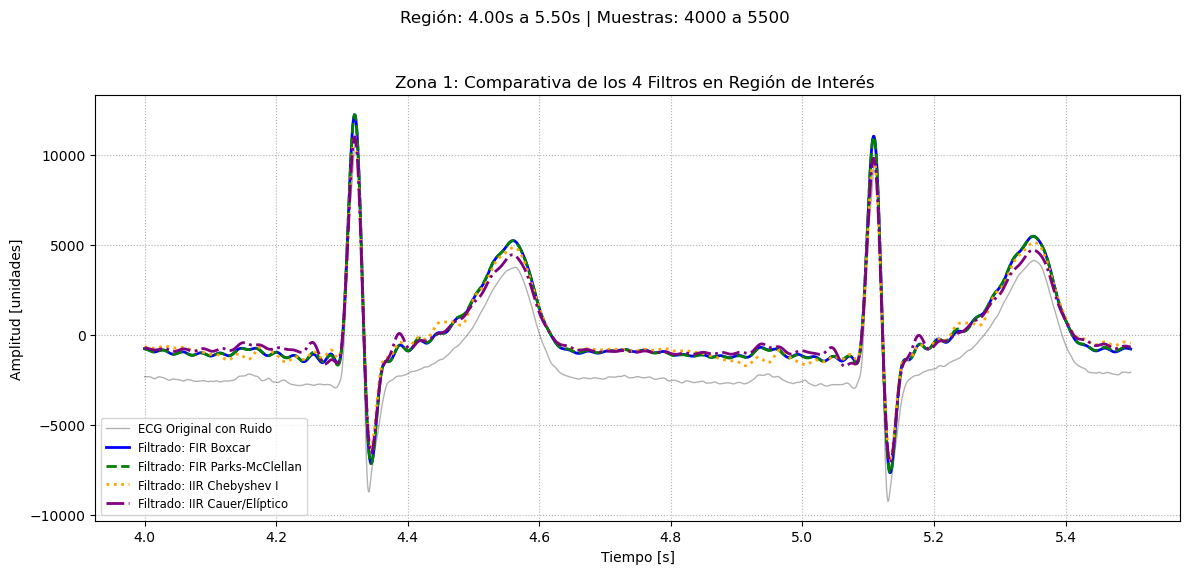

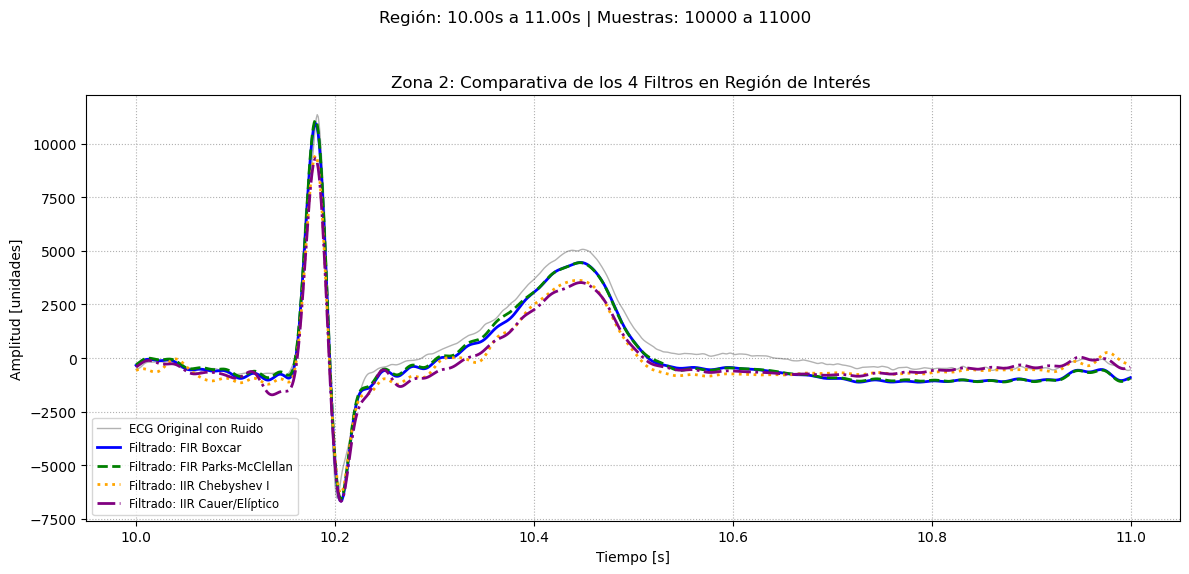

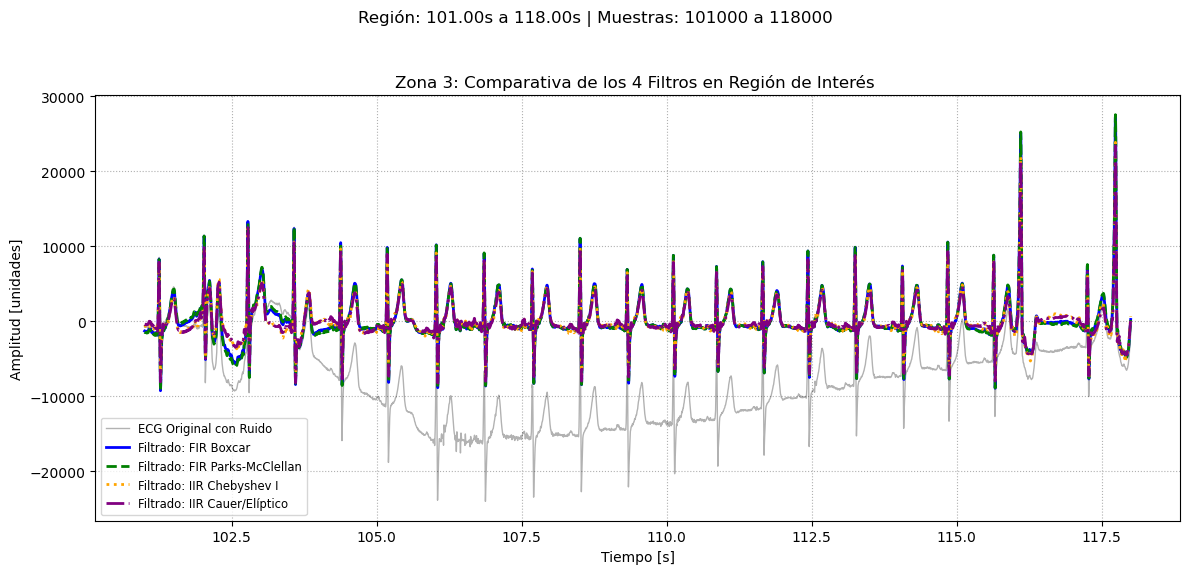

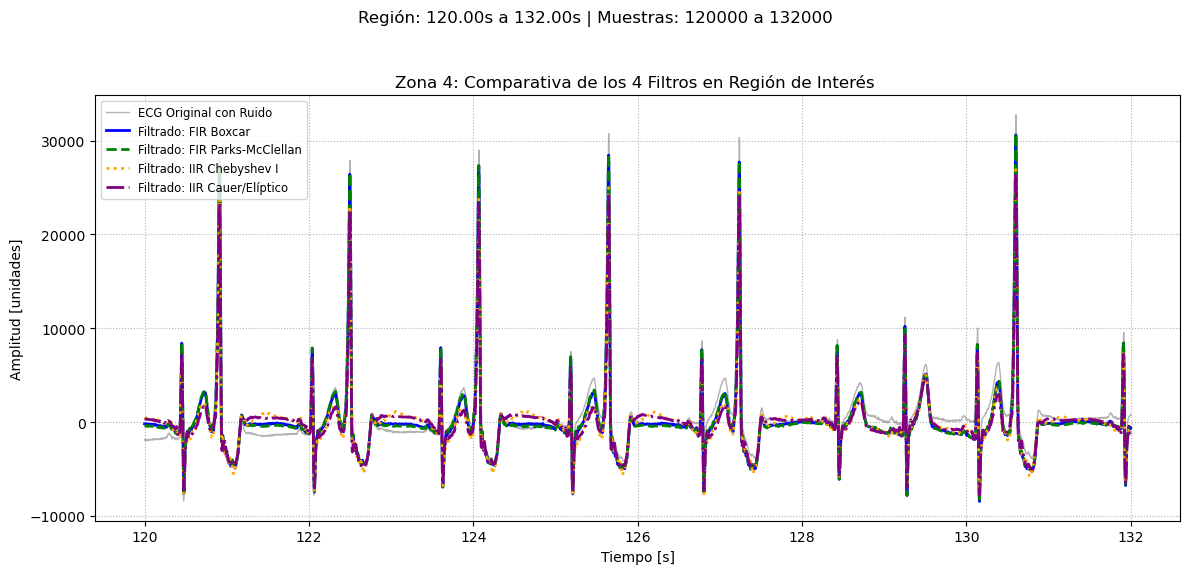

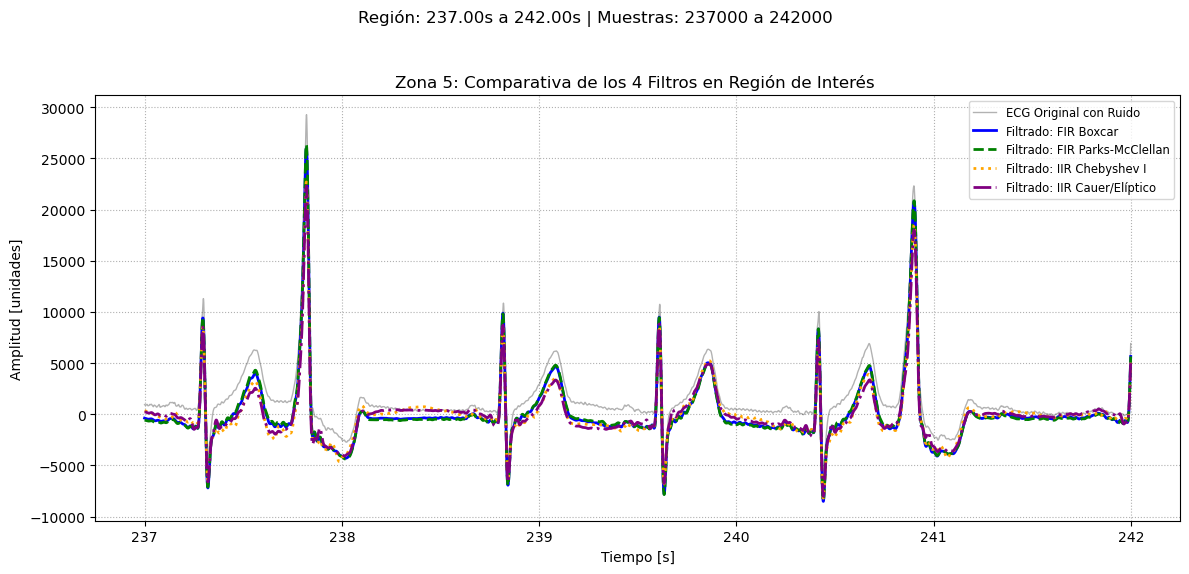

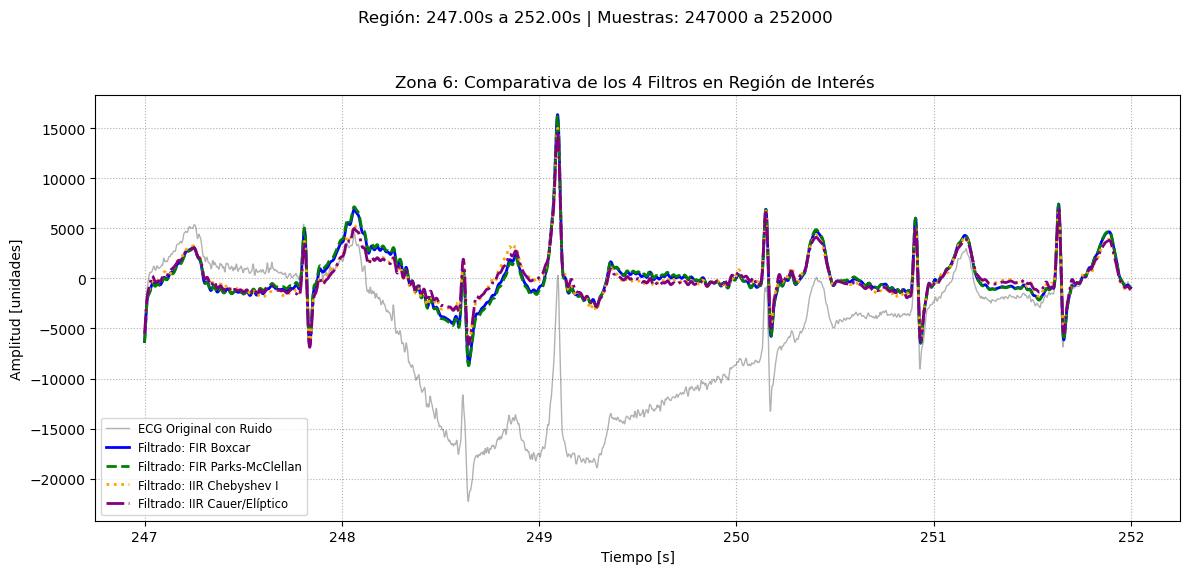

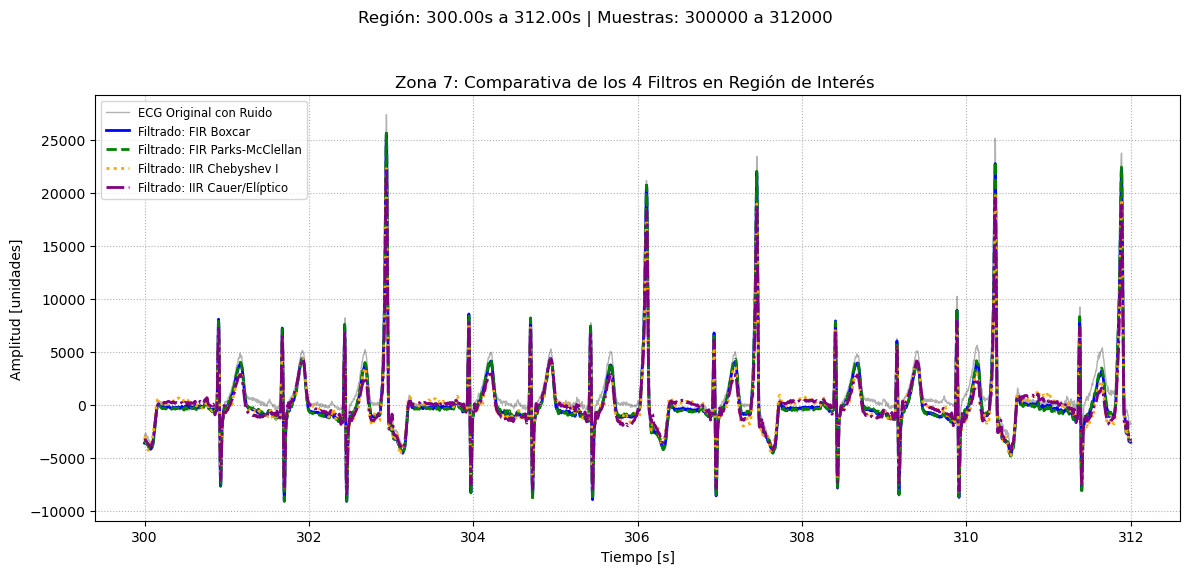

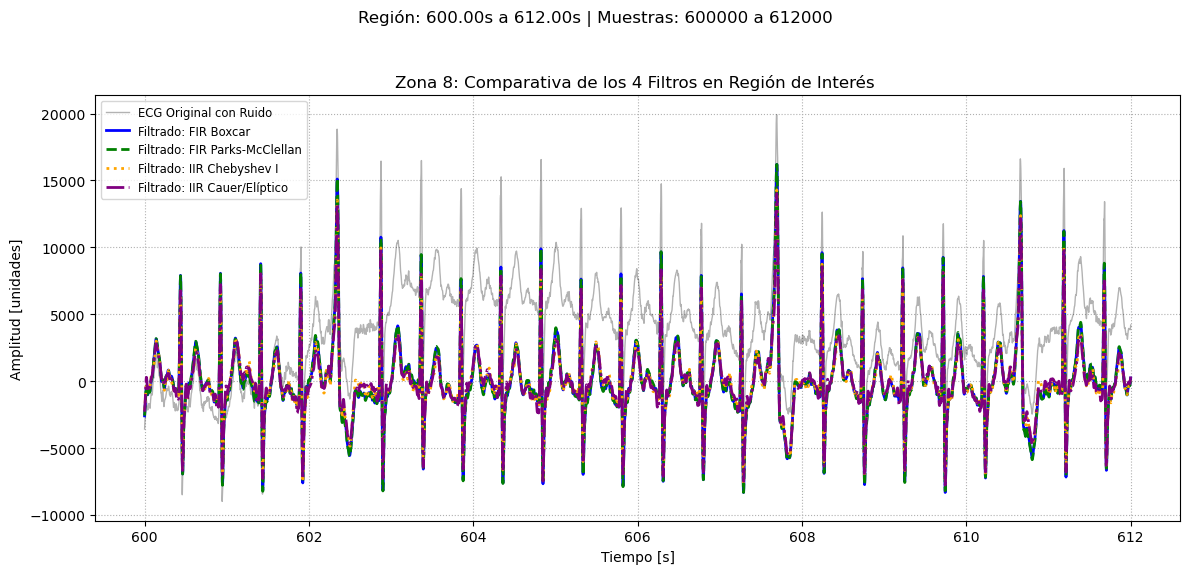

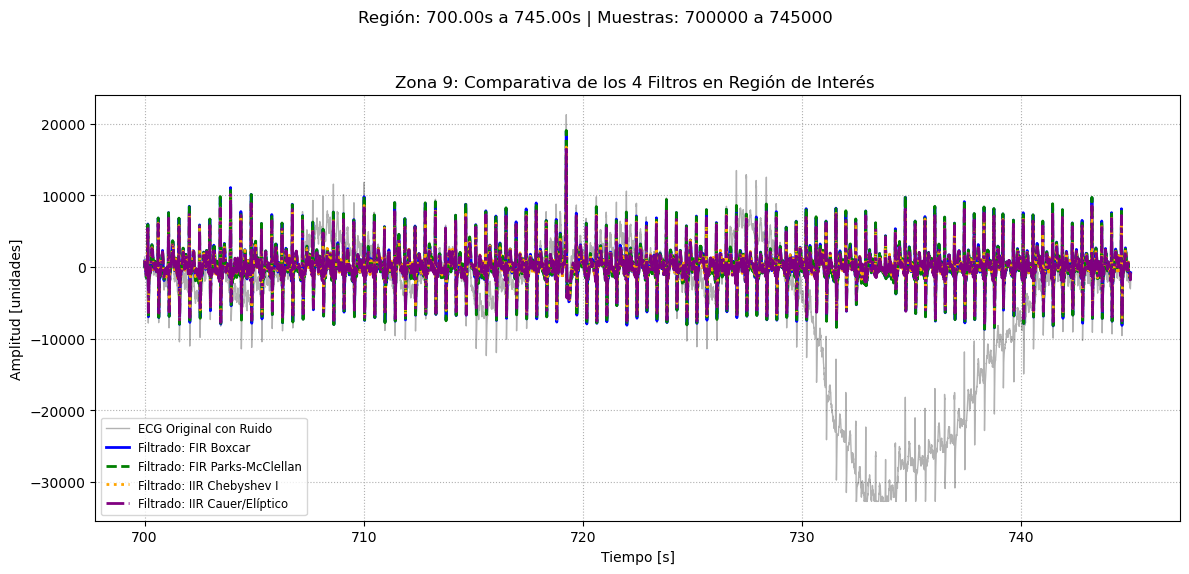

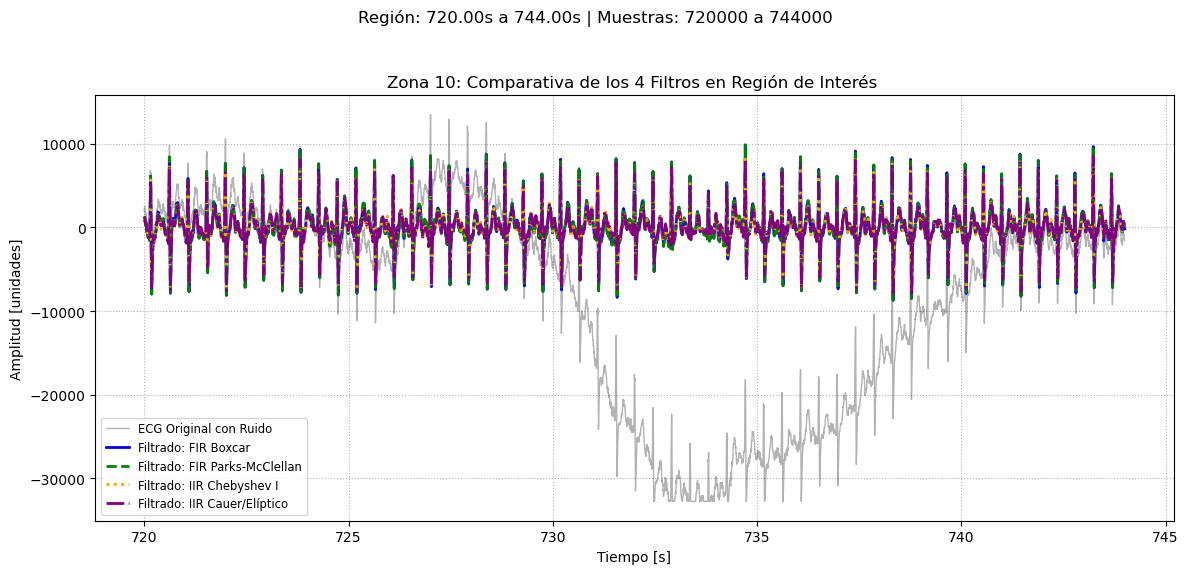

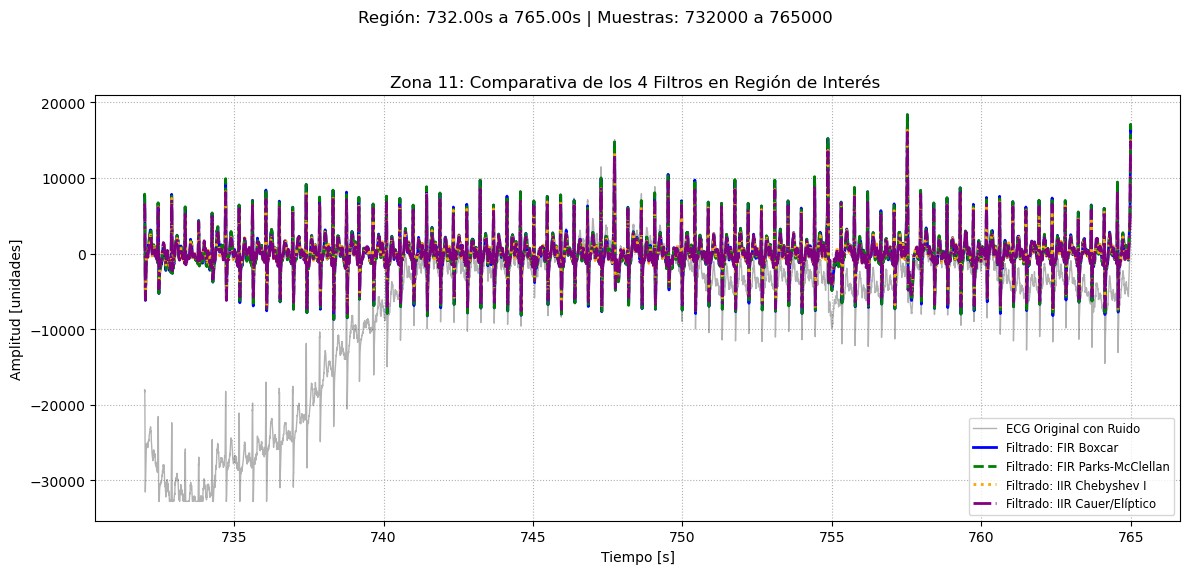

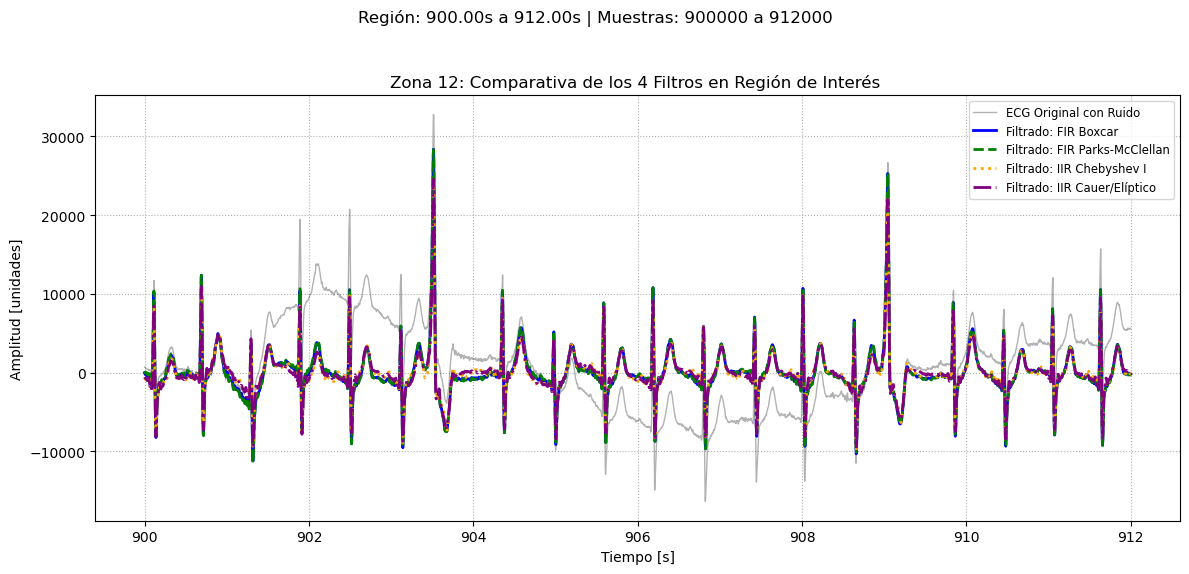

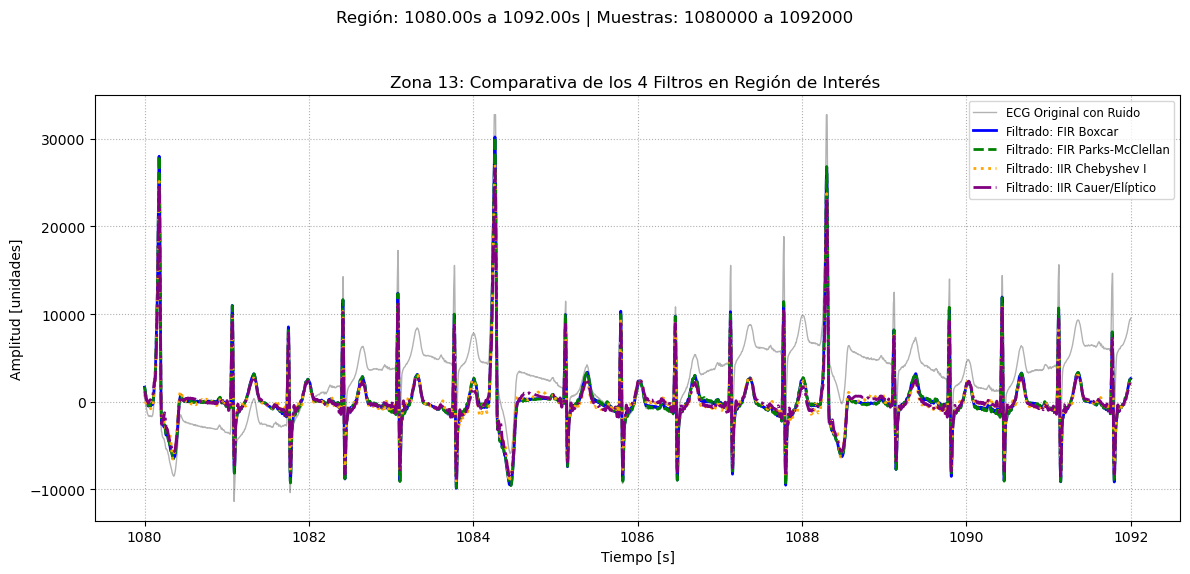

--- 13 Gráficos de Zoom Completados. ---

--- ¡Ejecución Completa!


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Aplica, evalúa y verifica la Respuesta en Frecuencia (Punto c).

Created on Wed Nov 12 22:05:31 2025

@author: Fernando Daniel Fiamberti
"""


import numpy as np
from scipy import signal as sig
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
import sys

# =========================================================================
# 1. Parámetros de Carga de Datos y Diseño
# =========================================================================

# Parámetros de carga
DATA_FILENAME = 'ecg.mat'
DATA_KEY = 'ecg_lead'
FS = 1000 # Frecuencia de muestreo (Hz)
N_SAMPLES_TO_USE = 1120000 

# Parámetros de la Región de Interés 
REGION_START = 50000 
REGION_END = 55000 

# ZONAS FINALES 
ZONAS_DE_INTERES_SOLICITADAS_Y_ORDENADAS = [
    (4000, 5500),         # 1. 4000 a 5500
    (10000, 11000),       # 2. 10000 a 11000
    (101000, 118000),     # 3. 101000 a 118000 (101s a 118s)
    (120000, 132000),     # 4. 120000 a 132000 (2 min a 2.2 min)
    (237000, 242000),     # 5. 237000 a 242000
    (247000, 252000),     # 6. 247000 a 252000
    (300000, 312000),     # 7. 300000 a 312000 (5 min a 5.2 min)
    # Zonas de minutos convertidas a muestras
    (600000, 612000),     # 8. 10 min a 10.2 min (600000 a 612000)
    (700000, 745000),     # 9. 700000 a 745000 (Existente)
    (720000, 744000),     # 10. 12 min a 12.4 min (720000 a 744000)
    (732000, 765000),     # 11. ZONA NUEVA SOLICITADA (732s a 765s)
    (900000, 912000),     # 12. 15 min a 15.2 min (900000 a 912000)
    (1080000, 1092000),   # 13. 18 min a 18.2 min (1080000 a 1092000)
]

# Las listas ZONAS_DE_INTERES y REGS_DE_INTERES_ADICIONALES se mantienen vacías/no utilizadas.
ZONAS_DE_INTERES = []
REGS_DE_INTERES_ADICIONALES = [] 

# Parámetros de Diseño
fs = FS
# IIR
alpha_p = 1 # Atenuación máxima en banda de paso (dB)
alpha_s = 40 # Atenuación mínima en banda de detención (dB)
wp = (0.8, 35) # Frecuencia de corte/paso (Hz)
ws_iir = (0.1, 40) # Frecuencia de stop/detenida IIR (Hz)
# FIR
N_fir = 3000 # Orden del filtro FIR
numtaps_fir = N_fir + 1
delta1_fir = 0.1
ws0_fir = 0.1
ws1_fir = 35.7

# --- PARÁMETRO PARA SUAVIZADO DE GRÁFICAS ---
N_FREQZ_POINTS = 32768 # Número de puntos para calcular la respuesta en frecuencia (más puntos = curvas más suaves)
# --- Puntos para el zoom de alta resolución de los IIR en baja frecuencia ---
N_FREQZ_ZOOM_POINTS = 50000 

# =========================================================================
# 2. Carga y Preparación de la Señal ECG con Ruido
# =========================================================================

try:
    print(f"Cargando {DATA_FILENAME}...")
    mat = sio.loadmat(DATA_FILENAME)
    ecg_ruido_full = np.squeeze(mat.get(DATA_KEY, None))
    
    if ecg_ruido_full is None:
        raise KeyError(f"La clave '{DATA_KEY}' no se encontró en {DATA_FILENAME}.")
        
    if len(ecg_ruido_full) >= N_SAMPLES_TO_USE:
        ecg_ruido_full = ecg_ruido_full[:N_SAMPLES_TO_USE]
        print(f"Cargadas {len(ecg_ruido_full)} muestras de ECG con ruido.")
    else:
        # Si la señal es más corta que 1120000, se usa la longitud total
        N_SAMPLES_TO_USE = len(ecg_ruido_full)
        ecg_ruido_full = ecg_ruido_full
        print(f"Advertencia: El archivo tiene menos de 1120000. Usando {N_SAMPLES_TO_USE} muestras.")

except (FileNotFoundError, KeyError, ValueError) as e:
    print(f"¡Error! No se pudo cargar o procesar '{DATA_FILENAME}': {e}")
    N_SAMPLES_TO_USE = 10000 
    t = np.arange(0, N_SAMPLES_TO_USE) / FS
    ecg_ruido_full = np.sin(2 * np.pi * 1 * t) + 1.5 * np.sin(2 * np.pi * 50 * t) 
    print("Usando ECG simulado de emergencia con ruido.")

N_signal = len(ecg_ruido_full)

# =========================================================================
# 3. Diseño de los 4 Filtros
# =========================================================================

# --- FIR Boxcar
f_deseada = [0, ws0_fir + delta1_fir, wp[0], wp[1], ws1_fir - delta1_fir, fs / 2]
m_deseada = [0, 0, 1, 1, 0, 0]
b_boxcar = sig.firwin2(numtaps=numtaps_fir, freq=f_deseada, gain=m_deseada, fs=fs, window='boxcar')

# --- FIR Parks-McClellan (Remez)
f_remez = [0, ws0_fir, wp[0], wp[1], ws1_fir, fs/2]
a_remez = [0, 1, 0] 
b_remez = sig.remez(numtaps=numtaps_fir, bands=f_remez, desired=a_remez, fs=fs, type='bandpass')

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sig.BadCoefficients)
    # --- IIR Chebyshev I
    N_cheb1, _ = sig.cheb1ord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=fs)
    mi_sos_cheb1 = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                                 analog=False, ftype='cheby1', output='sos', fs=fs)
    # --- IIR Cauer/Elíptico
    N_cauer, _ = sig.ellipord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=fs)
    mi_sos_cauer = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                                 analog=False, ftype='ellip', output='sos', fs=fs)

# =========================================================================
# 4. Aplicación de Filtrado
# =========================================================================

FILTROS = {
    'FIR Boxcar': {'b': b_boxcar, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_fir}'},
    'FIR Parks-McClellan': {'b': b_remez, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_fir}'},
    'IIR Chebyshev I': {'sos': mi_sos_cheb1, 'type': 'IIR', 'design_info': f'N={N_cheb1}'},
    'IIR Cauer/Elíptico': {'sos': mi_sos_cauer, 'type': 'IIR', 'design_info': f'N={N_cauer}'}
}

ecg_filtrado = {}

# Bloque de manejo de advertencias: suprime BadCoefficients durante el filtrado IIR
with warnings.catch_warnings():
    warnings.simplefilter("ignore", sig.BadCoefficients)
    
    for name, params in FILTROS.items():
        print(f"Aplicando filtro: {name}...")
        
        if params['type'] == 'FIR':
            ecg_filtrado[name] = sig.filtfilt(params['b'], params['a'], ecg_ruido_full)
            
        elif params['type'] == 'IIR':
            ecg_filtrado[name] = sig.sosfiltfilt(params['sos'], ecg_ruido_full)

print("\n--- Filtrado Completado para los 4 Diseños. ---")


# =========================================================================
# 6. Verificación de la Respuesta en Frecuencia 
# =========================================================================

print("\n--- Generando Gráficos de Verificación de Respuesta en Frecuencia (Punto c) ---")

# --- 6.1 Cálculo de la Respuesta en Frecuencia y Plantilla ---
respuestas = {}
eps = 1e-8

for name, params in FILTROS.items():
    
    is_iir_zoom = (name == 'IIR Cauer/Elíptico' or name == 'IIR Chebyshev I')
    
    if is_iir_zoom:
        # --- Cálculo en Alta Resolución para el Zoom IIR (0 a 1 Hz) ---
        sos = params['sos']
        # 50000 puntos en un rango muy estrecho (0 a 1 Hz).
        w_zoom_res, h_zoom_res = sig.sosfreqz(sos, fs=fs, worN=np.linspace(0, 1, N_FREQZ_ZOOM_POINTS, endpoint=False))

        # --- Cálculo Normal (de 1 Hz al final) y concatenación ---
        # 32768 puntos en todo el rango [0, fs/2], se toma solo la parte superior a 1 Hz
        w_norm, h_norm = sig.sosfreqz(sos, fs=fs, worN=N_FREQZ_POINTS)
        
        # Encontrar el índice más cercano a 1 Hz en el cálculo normal
        idx_start_norm = np.searchsorted(w_norm, 1.0)
        
        # Concatenar: Zoom de alta res (excluye el punto 0 Hz), y el resto normal.
        w = np.concatenate((w_zoom_res[1:], w_norm[idx_start_norm:]))
        h = np.concatenate((h_zoom_res[1:], h_norm[idx_start_norm:]))
        
        # Añadir el punto 0 Hz (DC) para asegurar el inicio del espectro.
        w = np.insert(w, 0, w_norm[0])
        h = np.insert(h, 0, h_norm[0])

    elif params['type'] == 'FIR':
        w, h = sig.freqz(params['b'], params['a'], fs=fs, worN=N_FREQZ_POINTS)
    elif params['type'] == 'IIR':
        # Cálculo normal para otros IIR si existieran, aunque solo hay 2 IIR definidos
        w, h = sig.sosfreqz(params['sos'], fs=fs, worN=N_FREQZ_POINTS)
    
    # Calcular fase y retardo de grupo 
    fase = np.unwrap(np.angle(h))
    group_delay = -np.diff(fase) / np.diff(w * 2 * np.pi) 
    
    respuestas[name] = {'w': w, 'h': h, 'fase': fase, 'group_delay': group_delay}

# Definición de la Plantilla de Diseño (Límites en dB)
limite_p_max = 20*np.log10(1 + eps)
limite_p_min = -alpha_p
limite_s_max = -alpha_s

# --- 6.2 Función de Ploteo Individual de la Plantilla ---
def plot_plantilla(ax):
    # Dibuja las bandas requeridas (PLANTILLA)
    ax.axvspan(0, ws_iir[0], color='red', alpha=0.1, label='Banda de Detención')
    ax.axvspan(wp[0], wp[1], color='green', alpha=0.1, label='Banda de Paso')
    ax.axvspan(ws_iir[1], fs/2, color='red', alpha=0.1) 
    # Líneas de las especificaciones (dB)
    ax.axhline(limite_p_max, color='black', linestyle=':', linewidth=1)
    ax.axhline(limite_p_min, color='black', linestyle=':', linewidth=1, label=f'-{alpha_p} dB')
    ax.axhline(limite_s_max, color='black', linestyle='--', linewidth=1, label=f'-{alpha_s} dB')
    ax.grid(True, which='both', ls=':')
    ax.set_xlim([0, 41]) # Límite superior 41 Hz

# --- 6.3 Gráficas de Verificación Individuales (4 Figuras) ---
for name, res in respuestas.items():
    # Solo 6 filas (2+2+2)
    plt.figure(figsize=(10, 18)) 
    
    # Magnitud Principal [dB]
    ax1 = plt.subplot(6, 1, (1, 2)) 
    w_zoom = res['w'][res['w'] <= 41] 
    h_zoom = res['h'][res['w'] <= 41] 
    ax1.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color='blue', linewidth=2)
    plot_plantilla(ax1)
    ax1.set_title(f'Magnitud Principal y Plantilla de Diseño - {name}')
    ax1.set_ylabel('|H(jω)| [dB]')
    ax1.set_ylim([-60, 5])
    ax1.legend(loc='lower left')
    
    # --- ZOOM 1: Baja Frecuencia (0Hz a 0.9Hz) ---
    ax_zoom_low = plt.subplot(6, 1, (3, 4)) 
    ax_zoom_low.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color='blue', linewidth=2)
    
    ax_zoom_low.axvspan(0, ws_iir[0], color='red', alpha=0.1)
    ax_zoom_low.axvspan(ws_iir[0], wp[0], color='yellow', alpha=0.1)
    ax_zoom_low.axhline(limite_s_max, color='red', linestyle='--', linewidth=1)
    ax_zoom_low.axhline(limite_p_min, color='green', linestyle=':', linewidth=1)
    
    is_iir_zoom = (name == 'IIR Cauer/Elíptico' or name == 'IIR Chebyshev I')
    
    # Título dinámico
    ax_zoom_low.set_title(f'Zoom Magnitud: Banda de Detención Baja y Transición ({0.6 if is_iir_zoom else 0}Hz a 0.9Hz)') 
    ax_zoom_low.set_ylabel('|H(jω)| [dB]')
    
    # Zoom de 0.6 Hz a 0.9 Hz para IIR Chebyshev I y Cauer
    if is_iir_zoom:
        ax_zoom_low.set_xlim([0.6, 0.9])
    else:
        ax_zoom_low.set_xlim([0, 0.9])
        
    ax_zoom_low.set_ylim([-60, 5]) 
    ax_zoom_low.grid(True, which='both', ls=':')
    
    # --- ZOOM 2: Alta Frecuencia (34Hz a 41Hz) ---
    ax_zoom_high = plt.subplot(6, 1, (5, 6)) 
    ax_zoom_high.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color='blue', linewidth=2)
    
    ax_zoom_high.axvspan(wp[1], ws_iir[1], color='yellow', alpha=0.1)
    ax_zoom_high.axvspan(ws_iir[1], 41, color='red', alpha=0.1)
    ax_zoom_high.axhline(limite_s_max, color='red', linestyle='--', linewidth=1)
    ax_zoom_high.axhline(limite_p_min, color='green', linestyle=':', linewidth=1)
    
    ax_zoom_high.set_title('Zoom Magnitud: Banda de Detención Alta y Transición (34Hz a 41Hz)')
    ax_zoom_high.set_ylabel('|H(jω)| [dB]')
    ax_zoom_high.set_xlim([34, 41])
    ax_zoom_high.set_ylim([-60, 5])
    ax_zoom_high.grid(True, which='both', ls=':')
    ax_zoom_high.set_xlabel('Frecuencia [Hz]')
    
    plt.suptitle(f'Verificación de Respuesta en Frecuencia - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 6.4 Gráfica de Verificación Comparativa (1 Figura) ---
plt.figure(figsize=(12, 20)) 

# Magnitud Principal [dB] - Comparativa
ax_comp_mag = plt.subplot(6, 1, (1, 2)) 
colores_comp = ['blue', 'green', 'orange', 'purple']
estilos_comp = ['-', '--', ':', '-.']
i = 0
for name, res in respuestas.items():
    w_zoom = res['w'][res['w'] <= 41] 
    h_zoom = res['h'][res['w'] <= 41] 
    ax_comp_mag.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    i += 1
plot_plantilla(ax_comp_mag)
ax_comp_mag.set_title('Respuesta en Magnitud Principal - Comparativa de los 4 Filtros vs. Plantilla')
ax_comp_mag.set_ylabel('|H(jω)| [dB]')
ax_comp_mag.set_ylim([-60, 5])
ax_comp_mag.legend(loc='lower left')

# --- ZOOM 1: Baja Frecuencia (0Hz a 0.9Hz) - Comparativa ---
ax_comp_zoom_low = plt.subplot(6, 1, (3, 4)) 
i = 0
for name, res in respuestas.items():
    # Usar el cálculo completo (incluyendo la alta resolución) para los IIR
    is_iir_zoom = (name == 'IIR Cauer/Elíptico' or name == 'IIR Chebyshev I')
    
    if is_iir_zoom:
        # Se grafican todos los puntos calculados (incluyendo la alta resolución)
        ax_comp_zoom_low.plot(res['w'], 20*np.log10(abs(res['h']) + eps), label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    else:
        w_zoom = res['w'][res['w'] <= 41] 
        h_zoom = res['h'][res['w'] <= 41] 
        ax_comp_zoom_low.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    
    i += 1

ax_comp_zoom_low.axvspan(0, ws_iir[0], color='red', alpha=0.1)
ax_comp_zoom_low.axvspan(ws_iir[0], wp[0], color='yellow', alpha=0.1)
ax_comp_zoom_low.axhline(limite_s_max, color='red', linestyle='--', linewidth=1)
ax_comp_zoom_low.axhline(limite_p_min, color='green', linestyle=':', linewidth=1)

ax_comp_zoom_low.set_title('Zoom Magnitud: Banda de Detención Baja y Transición (IIR con alta resolución)')
ax_comp_zoom_low.set_ylabel('|H(jω)| [dB]')
# El límite X se mantiene en [0, 0.9] en el comparativo para ver todos
ax_comp_zoom_low.set_xlim([0, 0.9]) 
ax_comp_zoom_low.set_ylim([-60, 5]) 
ax_comp_zoom_low.grid(True, which='both', ls=':')
ax_comp_zoom_low.legend(loc='lower left', fontsize='small')


# --- ZOOM 2: Alta Frecuencia (34Hz a 41Hz) - Comparativa ---
ax_comp_zoom_high = plt.subplot(6, 1, (5, 6))
i = 0
for name, res in respuestas.items():
    w_zoom = res['w'][res['w'] <= 41] 
    h_zoom = res['h'][res['w'] <= 41] 
    ax_comp_zoom_high.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    i += 1
    
ax_comp_zoom_high.axvspan(wp[1], ws_iir[1], color='yellow', alpha=0.1)
ax_comp_zoom_high.axvspan(ws_iir[1], 41, color='red', alpha=0.1)
ax_comp_zoom_high.axhline(limite_s_max, color='red', linestyle='--', linewidth=1)
ax_comp_zoom_high.axhline(limite_p_min, color='green', linestyle=':', linewidth=1)
    
ax_comp_zoom_high.set_title('Zoom Magnitud: Banda de Detención Alta y Transición (34Hz a 41Hz)')
ax_comp_zoom_high.set_ylabel('|H(jω)| [dB]')
ax_comp_zoom_high.set_xlim([34, 41])
ax_comp_zoom_high.set_ylim([-60, 5])
ax_comp_zoom_high.grid(True, which='both', ls=':')
ax_comp_zoom_high.legend(loc='lower left', fontsize='small')
ax_comp_zoom_high.set_xlabel('Frecuencia [Hz]')

plt.suptitle('Comparativa General de Respuesta en Frecuencia (Punto c)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# =========================================================================
# 5. Visualización de Resultados, Zonas de Interés Ordenadas
# =========================================================================

print(f"\n--- Generando {len(ZONAS_DE_INTERES_SOLICITADAS_Y_ORDENADAS)} Gráficos de Zoom ---")

ZONAS_FINALES = []

# Definición de las ubicaciones de leyenda solicitadas:
# Zona 4: 'upper left'
# Zona 5: 'upper right'
# Zona 7: 'upper left'
# Zona 8: 'upper left'
# Zona 11: 'lower right' (del pedido anterior)
# Zona 12: 'upper right'
# Zona 13: 'upper right'

for idx, (start_s, end_s) in enumerate(ZONAS_DE_INTERES_SOLICITADAS_Y_ORDENADAS):
    # Asegurar orden (start < end) y límites (dentro de N_signal)
    start_final = max(0, min(start_s, end_s))
    end_final = min(N_signal - 1, max(start_s, end_s))
    
    # Asegurar que el rango sea válido
    if end_final > start_final:
        ZONAS_FINALES.append((start_final, end_final))

    # Determinar la posición de la leyenda
    legend_loc = 'lower left' # Posición por defecto
    
    # Se utiliza el índice + 1 para identificar la zona (1-based index)
    zona_num = idx + 1 
    
    if zona_num == 4 or zona_num == 7 or zona_num == 8:
        # Zona 4 (120000, 132000), Zona 7 (300000, 312000), Zona 8 (600000, 612000)
        legend_loc = 'upper left'
    elif zona_num == 5 or zona_num == 12 or zona_num == 13:
        # Zona 5 (237000, 242000), Zona 12 (900000, 912000), Zona 13 (1080000, 1092000)
        legend_loc = 'upper right'
    elif zona_num == 11:
        # Zona 11 (732000, 765000) - Mantener 'lower right' del pedido anterior
        legend_loc = 'lower right'

    # ---------------------------------------------------------------------
    # Gráfica Individual de la Zona (Original vs. 4 Filtros)
    # ---------------------------------------------------------------------
    plt.figure(figsize=(12, 6))
    
    # Intervalo limitado de 0 a N_signal
    idx_zoom = np.arange(start_final, end_final, dtype='uint')
    
    t_zoom = idx_zoom / FS
    
    # Gráfico de la señal original con ruido
    plt.plot(t_zoom, ecg_ruido_full[idx_zoom], label='ECG Original con Ruido', color='black', alpha=0.3, linestyle='-', linewidth=1)
    
    colores_comp = ['blue', 'green', 'orange', 'purple']
    estilos_comp = ['-', '--', ':', '-.']
    i = 0
    for name, ecg_f in ecg_filtrado.items():
        plt.plot(t_zoom, ecg_f[idx_zoom], 
                 label=f'Filtrado: {name}', color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
        i += 1
        
    start_time = start_final / FS
    end_time = end_final / FS
    
    plt.title(f'Zona {idx+1}: Comparativa de los 4 Filtros en Región de Interés ')
    plt.suptitle(f'Región: {start_time:.2f}s a {end_time:.2f}s | Muestras: {start_final} a {end_final}')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud [unidades]')
    plt.grid(True, which='both', ls=':')
    
    # Aplicar la ubicación de la leyenda
    plt.legend(loc=legend_loc, fontsize='small')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
print(f"--- {len(ZONAS_FINALES)} Gráficos de Zoom Completados. ---")

print("\n--- ¡Ejecución Completa!")

# BONUS
## Señal telegráfica de audio de 939,31Hz con ruido
Mediante la Ts4 (Densidad Espectral de Potencia) determiné que la frecuencia del tono escuchado es de 939,91 Hz. En lo gráficos de la señal filtrada se observa el mensaje en forma de interrupción del tono de audio de 939,91 Hz. El mensaje es CQ CQ (llamado general a todas las estaciones), que en términos de puntos y rayas es: C = raya punto raya punto y Q = raya raya punto raya. Puede observarse esto en la duración correcta de la señal en el gráfico: la raya dura 3 veces el tiempo del punto.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CW_Comparativa_Filtrado_FINAL_COMPLETO_V9.py

Análisis para 50 Hz, 100 Hz, 250 Hz y 500 Hz, centrado en 939.91 Hz.
"""

import numpy as np
from scipy import signal as sig
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
import sys

# =========================================================================
# 0. CONFIGURACIÓN DE GRÁFICOS Y ENTORNO
# =========================================================================
# Configuramos Matplotlib para permitir más de 20 figuras abiertas sin advertencia.
plt.rcParams['figure.max_open_warning'] = 100

# Importación específica para reproductores de audio en Jupyter
try:
    from IPython.display import Audio, display, HTML
    JUPYTER_ENV = True
except ImportError:
    JUPYTER_ENV = False
    print("Advertencia: No se detectó IPython.display. Los reproductores de audio no se mostrarán.")


# =========================================================================
# 1. Parámetros Globales y Carga
# =========================================================================

DATA_FILENAME = 'CW.wav'
N_FIR = 4000      # Orden alto para forzar 80 dB de atenuación
alpha_p = 0.5     # Atenuación máxima en banda de paso (dB) para IIR
alpha_p_fir = 1.0    # Atenuación máxima en banda de paso (dB) para FIR
alpha_s = 80      # Atenuación mínima en banda de detención (dB) para IIR
alpha_s_remez = 80.0 # Restricción más estricta para Parks-McClellan

os.makedirs('resultados_CW_final', exist_ok=True)

try:
    print(f"Cargando {DATA_FILENAME}...")
    fs, signal_full = wavfile.read(DATA_FILENAME)
    if signal_full.ndim > 1:
        signal_full = signal_full[:, 0]
        
    audio_signal = signal_full.astype(np.float64) / np.max(np.abs(signal_full))
    
    FS = fs
    N_signal = len(audio_signal)
    print(f"Cargadas {N_signal} muestras. Frecuencia de muestreo: {FS} Hz")

except FileNotFoundError:
    print(f"¡Error! No se encontró el archivo '{DATA_FILENAME}'.")
    sys.exit()

# =========================================================================
# 1.5. Gráfico de la Señal Original (MODIFICACIÓN SOLICITADA)
# =========================================================================

# Crear el vector de tiempo
t_orig = np.arange(N_signal) / FS

plt.figure(figsize=(12, 4))
plt.plot(t_orig, audio_signal, color='blue', linewidth=1)
plt.title(f'Señal Original de Audio (CW.wav) - {N_signal} Muestras a {FS} Hz')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud Normalizada')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig('resultados_CW_final/00_Senial_Original_Tiempo.png', dpi=300)
# La llamada a plt.show() se mantiene al final del script para mostrar todos los gráficos juntos.

# =========================================================================
# 2. Definición de Diseños por Ancho de Banda (50 Hz, 100 Hz, 250 Hz, 500 Hz)
# =========================================================================

FC_TONE = 939.91 

# ---Anchos de Banda de Transición ---
T_FIR_KAISER = 30      
T_FIR_REMEZ = 50       


DESIGN_PARAMS = {
    '50': { 
        'BW_Hz': 50,
        # wp = [FC - 25, FC + 25]
        'wp': (FC_TONE - 25, FC_TONE + 25),      
        # ws_iir (Mínimo requerido para IIR, T=50Hz)
        'ws_iir': (FC_TONE - 75, FC_TONE + 75),      
        # ws_fir (Nueva, T=30Hz)
        'ws_fir': (FC_TONE - (25 + T_FIR_KAISER), FC_TONE + (25 + T_FIR_KAISER)), 
        # ws_remez (Nueva, T=50Hz)
        'ws_remez': (FC_TONE - (25 + T_FIR_REMEZ), FC_TONE + (25 + T_FIR_REMEZ)) 
    },
    '100': {
        'BW_Hz': 100,
        # wp = [FC - 50, FC + 50]
        'wp': (FC_TONE - 50, FC_TONE + 50),      
        # ws_iir (Mínimo requerido para IIR, T=50Hz)
        'ws_iir': (FC_TONE - 100, FC_TONE + 100),      
        # ws_fir (Nueva, T=30Hz)
        'ws_fir': (FC_TONE - (50 + T_FIR_KAISER), FC_TONE + (50 + T_FIR_KAISER)), 
        # ws_remez (Nueva, T=50Hz)
        'ws_remez': (FC_TONE - (50 + T_FIR_REMEZ), FC_TONE + (50 + T_FIR_REMEZ)) 
    },
    '250': {
        'BW_Hz': 250,
        # wp = [FC - 125, FC + 125]
        'wp': (FC_TONE - 125, FC_TONE + 125),      
        # ws_iir (Mínimo requerido para IIR, T=50Hz)
        'ws_iir': (FC_TONE - 175, FC_TONE + 175),      
        # ws_fir (Nueva, T=30Hz)
        'ws_fir': (FC_TONE - (125 + T_FIR_KAISER), FC_TONE + (125 + T_FIR_KAISER)), 
        # ws_remez (Nueva, T=50Hz)
        'ws_remez': (FC_TONE - (125 + T_FIR_REMEZ), FC_TONE + (125 + T_FIR_REMEZ)) 
    },
    '500': {
        'BW_Hz': 500,
        # wp = [FC - 250, FC + 250]
        'wp': (FC_TONE - 250, FC_TONE + 250),      
        # ws_iir (Mínimo requerido para IIR, T=50Hz)
        'ws_iir': (FC_TONE - 300, FC_TONE + 300), 
        # ws_fir (Nueva, T=30Hz)
        'ws_fir': (FC_TONE - (250 + T_FIR_KAISER), FC_TONE + (250 + T_FIR_KAISER)), 
        # ws_remez (Nueva, T=50Hz)
        'ws_remez': (FC_TONE - (250 + T_FIR_REMEZ), FC_TONE + (250 + T_FIR_REMEZ)) 
    }
}

# Guardo todas las señales filtradas (para la sección de audio final)
all_filtered_signals = {}
all_filtered_signals['Original'] = audio_signal 

# =========================================================================
# 3. Bucle Principal de Análisis
# =========================================================================

# MODIFICACIÓN APLICADA: Cambiar la iteración sobre DESIGN_PARAMS para ordenar las claves
# de mayor a menor ancho de banda ('500', '250', '100', '50').
for BW_KEY in ['500', '250', '100', '50']:
    params = DESIGN_PARAMS[BW_KEY]
    
    BW = params['BW_Hz']
    wp = params['wp']
    ws_iir = params['ws_iir']
    ws_fir = params['ws_fir'] 
    ws0_iir, ws1_iir = ws_iir
    ws0_fir, ws1_fir = ws_fir 
    ws0_remez, ws1_remez = params['ws_remez']
    wp0, wp1 = wp
    
    print(f"\n#################################################")
    print(f"## INICIANDO ANÁLISIS PARA BW = {BW} Hz (FC={FC_TONE:.2f} Hz) ##")
    print(f"#################################################")

    # --- 3.1. Diseño de los 4 Filtros para el BW actual ---

    # 1. FIR Kaiser
    # Usa alpha_s = 80 dB
    if alpha_s > 50:
        beta_kaiser = 0.1102 * (alpha_s - 8.7)
    elif alpha_s >= 21:
        beta_kaiser = 0.5842 * (alpha_s - 21)**0.4 + 0.07886 * (alpha_s - 21)
    else:
        beta_kaiser = 0.0
        
    f_corte_low = (wp0 + ws0_fir) / 2
    f_corte_high = (wp1 + ws1_fir) / 2
    b_boxcar = sig.firwin(numtaps=N_FIR, cutoff=[f_corte_low, f_corte_high], fs=FS, 
                              window=('kaiser', beta_kaiser), pass_zero=False)
    

    # 2. FIR Parks-McClellan (Remez)
    f_remez = [0, ws0_remez, wp0, wp1, ws1_remez, FS/2]
    a_remez = [0, 1, 0] 
    # Peso Remez se calcula en base a alpha_p_fir (1.0 dB) y alpha_s_remez (80.0 dB)
    remez_weight = (10**(alpha_p_fir/20) - 1) / (10**(-alpha_s_remez/20)) 
    b_remez_raw = sig.remez(numtaps=N_FIR, bands=f_remez, desired=a_remez, fs=FS, type='bandpass', 
                                 weight=[remez_weight, 1, remez_weight]) 
    
    # --- Normalización de Remez (Mantenida sin cambios) ---
    w_remez_test, h_remez_test = sig.freqz(b_remez_raw, 1, worN=10000, fs=FS)
    bp_mask_test = (w_remez_test >= wp0) & (w_remez_test <= wp1)
    if np.any(bp_mask_test):
        max_gain_bp = np.max(np.abs(h_remez_test[bp_mask_test]))
        if max_gain_bp > 0:
            b_remez = b_remez_raw / max_gain_bp # Normalizamos para que la ganancia máxima en BP sea 1 (0 dB)
        else:
            b_remez = b_remez_raw
            print(f"Advertencia: Ganancia cero detectada en Remez para BW={BW}Hz.")
    else:
        b_remez = b_remez_raw
        print(f"Advertencia: Máscara BP vacía para Remez en BW={BW}Hz. No se normalizó.")
    # ----------------------------------------------------

    # Suprimir advertencias de diseño IIR
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sig.BadCoefficients)
        
        # 3. IIR Chebyshev I (Usa alpha_p = 0.5 dB y alpha_s = 80 dB)
        N_cheb1, _ = sig.cheb1ord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=FS)
        mi_sos_cheb1 = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                                            analog=False, ftype='cheby1', output='sos', fs=FS)
        
        # 4. IIR Cauer/Elíptico (Usa alpha_p = 0.5 dB y alpha_s = 80 dB)
        N_cauer, _ = sig.ellipord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=FS)
        mi_sos_cauer = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                                            analog=False, ftype='ellip', output='sos', fs=FS)

    # --- 3.2. Estructura de Filtros y Aplicación ---
    
    FILTROS_DESIGN = {
        'FIR Kaiser': {'b': b_boxcar, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_FIR}, ap={alpha_p_fir}dB, as={alpha_s}dB, T={T_FIR_KAISER}Hz'}, 
        'FIR Parks-McClellan': {'b': b_remez, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_FIR}, ap={alpha_p_fir}dB, as={alpha_s_remez}dB, T={T_FIR_REMEZ}Hz'}, 
        'IIR Chebyshev I': {'sos': mi_sos_cheb1, 'type': 'IIR', 'design_info': f'N={N_cheb1}, ap={alpha_p}dB, as={alpha_s}dB, L={len(mi_sos_cheb1)}'}, 
        'IIR Cauer/Elíptico': {'sos': mi_sos_cauer, 'type': 'IIR', 'design_info': f'N={N_cauer}, ap={alpha_p}dB, as={alpha_s}dB, L={len(mi_sos_cauer)}'} 
    }
    
    cw_filtrado = {}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sig.BadCoefficients) 
        
        for name, filter_params in FILTROS_DESIGN.items():
            print(f"Aplicando filtro: {name} (BW={BW} Hz)...")
            
            if filter_params['type'] == 'FIR':
                signal_out = sig.lfilter(filter_params['b'], filter_params['a'], audio_signal)
                
            elif filter_params['type'] == 'IIR':
                signal_out = sig.sosfilt(filter_params['sos'], audio_signal)
            
            # Normalizar la salida y guardar en el diccionario general
            max_amp = np.max(np.abs(signal_out))
            normalized_signal = signal_out / max_amp if max_amp > 0 else signal_out
            
            # Usar un nombre único para el almacenamiento general
            full_name = f"{BW_KEY}Hz_{name}"
            all_filtered_signals[full_name] = normalized_signal
            cw_filtrado[name] = normalized_signal 

    print("\n--- Filtrado Completado. ---")
    
    # --- 3.3. Cálculo de Respuestas y Métricas y Generación de Gráficos ---
    
    # Rango de frecuencia forzado para TODOS los plots de respuesta de frecuencia: 500 Hz a 1400 Hz
    freq_range_plot_all = np.linspace(500, 1400, 10000)

    all_responses = {}
    performance_data = []

    for name, filter_params in FILTROS_DESIGN.items():
        
        # Determinar el rango de plot y los límites X para la figura
        # *** MODIFICADO PARA FORZAR RANGO DE 500Hz a 1400Hz ***
        freq_range_plot = freq_range_plot_all
        xlim_low, xlim_high = 500, 1400
        # ******************************************************
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning) 
            
            if filter_params['type'] == 'FIR':
                w, h = sig.freqz(filter_params['b'], filter_params['a'], worN=freq_range_plot, fs=FS)
                w_gd, gd = sig.group_delay((filter_params['b'], filter_params['a']), w=freq_range_plot, fs=FS)
            elif filter_params['type'] == 'IIR':
                w, h = sig.sosfreqz(filter_params['sos'], worN=freq_range_plot, fs=FS)
                b_tf, a_tf = sig.sos2tf(filter_params['sos'])
                w_gd, gd = sig.group_delay((b_tf, a_tf), w=freq_range_plot, fs=FS)
        
        mag_db = 20 * np.log10(np.abs(h) + 1e-8)
        phase = np.unwrap(np.angle(h))
        
        all_responses[name] = {'w': w, 'mag_db': mag_db, 'phase': phase, 'gd': gd, 
                               'design_info': filter_params['design_info'], 
                               'xlim_low': xlim_low, 'xlim_high': xlim_high} 
        
        # Extracción de Métricas
        bp_mask = (w >= wp0) & (w <= wp1)
        max_ripple = np.max(np.abs(mag_db[bp_mask])) if np.any(bp_mask) else np.nan
        
        # Definir la atenuación de paso (alpha_p) y los límites de banda de rechazo (ws)
        if filter_params['type'] == 'FIR':
            alpha_p_current = alpha_p_fir # 1.0 dB
            alpha_s_current = alpha_s_remez # 80dB
            if 'Parks-McClellan' in name:
                bs_low_mask = (w >= 0) & (w <= ws0_remez) 
                bs_high_mask = (w >= ws1_remez) & (w <= FS/2) 
                ws_low_line, ws_high_line = ws0_remez, ws1_remez
                ws_label = f'Bs Remez ({ws0_remez:.2f}/{ws1_remez:.2f}Hz)'
            else: # Kaiser
                alpha_s_current = alpha_s # 80dB
                bs_low_mask = (w >= 0) & (w <= ws0_fir) 
                bs_high_mask = (w >= ws1_fir) & (w <= FS/2) 
                ws_low_line, ws_high_line = ws0_fir, ws1_fir
                ws_label = f'Bs Kaiser ({ws0_fir:.2f}/{ws1_fir:.2f}Hz)'
        else: # IIR
            alpha_p_current = alpha_p # 0.5 dB
            alpha_s_current = alpha_s # 80dB
            bs_low_mask = (w >= 0) & (w <= ws0_iir)
            bs_high_mask = (w >= ws1_iir) & (w <= FS/2)
            ws_low_line, ws_high_line = ws0_iir, ws1_iir
            ws_label = f'Bs IIR Estandar ({ws0_iir:.2f}/{ws1_iir:.2f}Hz)'
            
        min_atten_low = -np.min(mag_db[bs_low_mask]) if np.any(bs_low_mask) else np.nan
        min_atten_high = -np.min(mag_db[bs_high_mask]) if np.any(bs_high_mask) else np.nan
        min_attenuation = np.min([min_atten_low, min_atten_high])
        
        orden_str = filter_params['design_info'].split(',')[0].strip()
        avg_gd = np.mean(gd[bp_mask]) if np.any(bp_mask) else np.nan
        
        performance_data.append({
            'Filtro': name,
            'Orden (N)': orden_str,
            'Rizo Máx en BP (dB)': f"{max_ripple:.4f}",
            'Atenuación Mín en BS (dB)': f"{min_attenuation:.1f}" if min_attenuation != np.nan else "N/A",
            'Retardo de Grupo Prom (muestras)': f"{avg_gd:.1f}"
        })
        
        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "").replace("/", "_")
        
        # --- Gráfico de Magnitud Individual para CADA FILTRO ---
        fig_height_individual = 8 
        plt.figure(figsize=(8, fig_height_individual))
        
        plt.plot(w, mag_db)
        plt.title(f'Magnitud: {name} (BW={BW} Hz, FC={FC_TONE:.2f} Hz)', fontsize=12)
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud (dB)')
        plt.xlim(xlim_low, xlim_high) 
        plt.ylim(-alpha_s - 10, alpha_p_fir + 1) 
        
        # Línea de límite de Banda de Paso (usa alpha_p_current)
        plt.axhline(alpha_p_current, color='r', linestyle='--', alpha=0.5, label=f'Límite Bp ({alpha_p_current} dB)') 
        
        # Línea de límite de Banda de Rechazo
        plt.axhline(-alpha_s_current, color='g', linestyle='--', alpha=0.5, label=f'Límite Bs (-{alpha_s_current} dB)') 
        
        # Líneas de Banda de Rechazo (ws)
        plt.axvline(ws_low_line, color='m' if 'Parks-McClellan' in name else ('c' if 'Kaiser' in name else 'k'), 
                                 linestyle=':', alpha=0.8, label=ws_label)
        plt.axvline(ws_high_line, color='m' if 'Parks-McClellan' in name else ('c' if 'Kaiser' in name else 'k'), 
                                 linestyle=':', alpha=0.8)

        # Líneas de Banda de Paso (wp)
        plt.axvline(wp0, color='b', linestyle=':', alpha=0.5)
        plt.axvline(wp1, color='b', linestyle=':', alpha=0.5, label='Banda de Paso')
        plt.legend(loc='upper right', fontsize=8) 
        
        plt.grid(True, which="both", ls="--")
        plt.tight_layout()
        plt.savefig(f'resultados_CW_final/BW{BW}_Magnitud_{safe_name}_INDIVIDUAL.png', dpi=300)


    # --- Gráficos Comparativos (SÓLO Magnitud para el BW actual) ---
    
    plt.figure(figsize=(12, 8)) # Altura de referencia: 8
    plt.suptitle(f'Comparación de Magnitud de Filtros (BW={BW} Hz) - Centrado en {FC_TONE:.2f} Hz', fontsize=14)
    
    xlim_comparative = 1400 
    
    for name, res in all_responses.items():
        plt.plot(res['w'], res['mag_db'], label=f'{name}')
        
    plt.title(f'Plantilla: Bp=[{wp0:.2f}-{wp1:.2f}]Hz. as=80dB. FIR: ap={alpha_p_fir}dB, T={T_FIR_KAISER}/{T_FIR_REMEZ}Hz. IIR: ap={alpha_p}dB.') 
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud (dB)')
    plt.xlim(500, xlim_comparative) 
    plt.ylim(-alpha_s - 10, alpha_p_fir + 1) 
    plt.legend(loc='lower left', fontsize=9)
    plt.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_Magnitud_COMPARATIVA.png', dpi=300)

    # --- INICIO DE MODIFICACIONES SOLICITADAS: FASE y RETARDO DE GRUPO ---
    
    # --- Gráficos Comparativos (FASE para el BW actual) ---
    
    plt.figure(figsize=(12, 8)) 
    plt.suptitle(f'Comparación de FASE de Filtros (BW={BW} Hz) - Centrado en {FC_TONE:.2f} Hz', fontsize=14)
    
    # Líneas de Banda de Paso (wp)
    plt.axvline(wp0, color='r', linestyle=':', alpha=0.5, label='Banda de Paso')
    plt.axvline(wp1, color='r', linestyle=':', alpha=0.5)

    for name, res in all_responses.items():
        # Usar la fase desenrollada ya calculada
        linewidth = 2.5 if 'FIR' in name else 1.5
        color = 'red' if 'Parks-McClellan' in name else ('blue' if 'Kaiser' in name else ('green' if 'Chebyshev' in name else 'purple'))
        plt.plot(res['w'], res['phase'], label=f'{name}', linewidth=linewidth, color=color)
        
    plt.title(f'FASE (Desenrollada) de la Respuesta de Frecuencia') 
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Fase (radianes)')
    plt.xlim(500, xlim_comparative) 
    plt.legend(loc='lower left', fontsize=9)
    plt.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_Fase_COMPARATIVA.png', dpi=300)
    
    
    # --- Gráficos Comparativos (RETARDO DE GRUPO para el BW actual) ---
    
    plt.figure(figsize=(12, 8)) 
    plt.suptitle(f'Comparación de RETARDO DE GRUPO (BW={BW} Hz) - Centrado en {FC_TONE:.2f} Hz', fontsize=14)
    
    # GD constante de los FIR (N-1)/2 = (4000-1)/2 = 1999.5
    GD_FIR_THEORETICAL = (N_FIR - 1) / 2
    
    # Líneas de Banda de Paso (wp)
    plt.axvline(wp0, color='r', linestyle=':', alpha=0.5, label='Banda de Paso')
    plt.axvline(wp1, color='r', linestyle=':', alpha=0.5)
    
    # Línea de referencia para el GD constante del FIR
    plt.axhline(GD_FIR_THEORETICAL, color='red', linestyle='--', alpha=0.5, label=f'GD FIR Constante ({GD_FIR_THEORETICAL:.1f} muestras)') 

    for name, res in all_responses.items():
        # Usar el Retardo de Grupo ya calculado
        linewidth = 2.5 if 'FIR' in name else 1.5
        color = 'red' if 'Parks-McClellan' in name else ('blue' if 'Kaiser' in name else ('green' if 'Chebyshev' in name else 'purple'))
        
        plt.plot(res['w'], res['gd'], label=f'{name}', linewidth=linewidth, color=color)
        
    plt.title(f'Retardo de Grupo (Group Delay) en la Banda de Paso') 
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo de Grupo (muestras)')
    plt.xlim(500, xlim_comparative) 
    
    # Ajustar el límite Y para enfocarse en la zona relevante (GD del FIR y picos del IIR)
    # Se usará un límite fijo de 2500 para mostrar el GD constante de 1999.5 de los FIR y capturar los picos de los IIR de forma razonable.
    plt.ylim(0, max(2500, GD_FIR_THEORETICAL * 1.2)) 
    
    plt.legend(loc='upper right', fontsize=9)
    plt.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_GD_COMPARATIVA.png', dpi=300)

    # --- FIN DE MODIFICACIONES SOLICITADAS: FASE y RETARDO DE GRUPO ---


    # --- 3.6. Gráficos de Señal Filtrada (Tiempo) ---
    t = np.arange(N_signal) / FS
    y_original = audio_signal
    
    # Cuatro Gráficos Individuales 
    for i, (name, signal) in enumerate(cw_filtrado.items()):
        
        plt.figure(figsize=(12, 8))
        plt.suptitle(f'Señal Original vs. Filtrada con {name} (BW={BW} Hz) - Tono {FC_TONE:.2f} Hz', fontsize=14)
        plt.plot(t, y_original, label='Señal Original (CW)', color='gray', alpha=0.7)
        
        linewidth = 2.5 if 'FIR' in name else 1
        color = 'red' if 'Parks-McClellan' in name else ('blue' if 'Kaiser' in name else ('green' if 'Chebyshev' in name else 'purple'))
            
        plt.plot(t, signal, label=f'Filtrada con {name}', color=color, linewidth=linewidth)
        plt.title(f'Detalle Temporal de la Señal Filtrada ({name})', fontsize=12)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "").replace("/", "_")
        plt.savefig(f'resultados_CW_final/BW{BW}_Senial_{safe_name}_INDIVIDUAL_TIEMPO.png', dpi=300)


    # Gráfico Comparativo 
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Comparación de Señal Filtrada (BW={BW} Hz) - Tono {FC_TONE:.2f} Hz', fontsize=14)

    plt.plot(t, y_original, label='Señal Original (CW)', color='black', alpha=0.5, linewidth=1)

    for name, signal in cw_filtrado.items():
        linewidth = 2.5 if 'FIR' in name else 1
        color = 'red' if 'Parks-McClellan' in name else ('blue' if 'Kaiser' in name else ('green' if 'Chebyshev' in name else 'purple'))
        plt.plot(t, signal, label=f'Filtrada con {name}', color=color, linewidth=linewidth, linestyle='--')

    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend(loc='upper right', fontsize=9)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_Senial_Filtrada_COMPARATIVA_TIEMPO.png', dpi=300)


    # --- 3.7. Imprimir Tabla de Rendimiento ---
    tabla_performance = pd.DataFrame(performance_data)
    print(f"\n--- TABLA DE RENDIMIENTO NUMÉRICO (BW={BW} Hz) ---\n")
    print(tabla_performance.to_string(index=False)) 
    tabla_performance.to_csv(f'resultados_CW_final/BW{BW}_Performance_Tabla.csv', index=False)


# =========================================================================
# 4. Mostrar todos los gráficos creados
# =========================================================================
plt.show()

# =========================================================================
# 5. Reproductores de Audio para Comparación y Generación de HTML 
# =========================================================================

TEMP_DIR = 'temp_audio_files'
os.makedirs(TEMP_DIR, exist_ok=True) # Aseguramos la creación de la carpeta
HTML_FILENAME = 'audio_players.html'

FILTROS_BASE = ['FIR Kaiser', 'FIR Parks-McClellan', 'IIR Chebyshev I', 'IIR Cauer/Elíptico']

def get_audio_path_and_save(signal, name):
    """Guarda la señal y devuelve la ruta relativa para el HTML."""
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "").replace("/", "_")
    temp_filename = os.path.join(TEMP_DIR, f"{safe_name}.wav")
    
    audio_int16 = (signal * 32767).astype(np.int16)
    wavfile.write(temp_filename, FS, audio_int16)
    
    # Devuelve la ruta relativa que el HTML debe usar
    return os.path.join(TEMP_DIR, f"{safe_name}.wav") # <--- CORREGIDO: Se quitó el 'os.' duplicado

def generate_html_players():
    """Genera el contenido HTML con reproductores de audio, con los 4 anchos de banda en una fila."""
    html_content = f"""
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <title>Comparación de Filtros de Audio</title>
        <style>
            /* MODIFICACIÓN APLICADA: Se añade el prefijo #audio-comparison a todos los selectores 
               para aislar los estilos y evitar que afecten la interfaz global de Jupyter. */
            #audio-comparison {{ font-family: Arial, sans-serif; margin: 20px; }}
            #audio-comparison .container {{ border: 2px solid #0056b3; padding: 15px; margin-bottom: 30px; border-radius: 8px; }}
            #audio-comparison h1, #audio-comparison h2, #audio-comparison h4 {{ color: #0056b3; border-bottom: 1px solid #ccc; padding-bottom: 5px; }}
            /* MODIFICACIÓN CLAVE: Usar flexbox para mantener los 4 elementos en una fila, distribuidos equitativamente. */
            #audio-comparison .grid {{ display: flex; flex-wrap: wrap; justify-content: space-between; gap: 10px; }} 
            #audio-comparison .col {{ 
                flex: 1 1 48%; /* ANCHO MODIFICADO: De 25% a 48% para que quepan 2 por fila con espacio entre ellos (casi la mitad) */
                padding: 10px; 
                box-sizing: border-box; 
                text-align: center; /* Centrar el contenido de la columna */
            }}
            #audio-comparison .col:nth-child(even) {{ border-right: none; }} /* Eliminar borde del segundo elemento en la fila */
            #audio-comparison .col:nth-child(odd) {{ border-right: 1px solid #eee; }} /* Mantener borde en el primer elemento */
            #audio-comparison p {{ font-weight: bold; margin-bottom: 5px; color: #333; font-size: 0.9em; }}
        </style>
    </head>
    <body>
        <div id="audio-comparison">
        <h1> Comparativa de Señales Filtradas ({FC_TONE:.2f} Hz)</h1>
        <p><strong>Rutas:</strong> El archivo <code>{HTML_FILENAME}</code> asume que la carpeta <code>{TEMP_DIR}</code> está en el mismo nivel.</p>
        <p><strong>Nota para Notebooks:</strong> Esta tabla HTML se genera y muestra aquí.  <code>{TEMP_DIR}</code>.</p>

        <div class="container">
            <h2>Señal Original (Arriba de todo, sin filtro)</h2>
            <audio controls src="{get_audio_path_and_save(all_filtered_signals['Original'], 'Original')}">
                Su navegador no soporta el elemento de audio.
            </audio>
        </div>

        <h2>Comparativas por Tipo de Filtro (4 anchos de banda, ahora 2 por fila)</h2>
    """
    
    # Definir el orden de los anchos de banda, de mayor a menor (de izquierda a derecha)
    # MODIFICACIÓN: La generación del HTML ya estaba en orden descendente ('500', '250', '100', '50'). Se mantiene.
    BW_ORDER = ['500', '250', '100', '50']
    
    # Recorrer todos los tipos de filtro
    for base_name in FILTROS_BASE:
        
        # Generar el bloque HTML para el filtro actual
        combined_html = f"""
        <div class="container">
            <h4>{base_name}</h4>
            <div class="grid">
        """
        
        # Recorrer los anchos de banda en el orden deseado
        for bw_key in BW_ORDER:
            
            # Obtener el nombre completo y la ruta del archivo
            full_name = f"{bw_key}Hz_{base_name}"
            path = get_audio_path_and_save(all_filtered_signals.get(full_name), full_name)
            label = f"BW = {bw_key}Hz"
            if bw_key == '50':
                label += " (Máx. Selectividad)"
            elif bw_key == '500':
                label += " (Mín. Selectividad)"
            
            # Añadir la columna al bloque HTML
            combined_html += f"""
                <div class="col">
                    <p>{label}</p>
                    <audio controls src="{path}">Su navegador no soporta audio.</audio>
                </div>
            """

        combined_html += """
            </div>
        </div>
        """
        html_content += combined_html

    html_content += """
        </div> </body>
    </html>
    """
    return html_content

# --- Ejecución de Generación y Guardado ---

# 1. Ejecutar el guardado de todos los archivos WAV y generar el HTML
final_html_content = generate_html_players()

# 2. Guardar el archivo HTML
try:
    with open(HTML_FILENAME, 'w') as f:
        f.write(final_html_content)
    print(f"\n####################################################")
    print(f"## ÉXITO: Archivo HTML generado para Navegador/GitHub ##")
    print(f"####################################################")
    print(f"1. Archivos WAV guardados en: '{TEMP_DIR}'")
    print(f"2. Archivo HTML generado: '{HTML_FILENAME}'")
    
    if JUPYTER_ENV:
        print("\n3. Visualizando la tabla de reproductores en el Notebook (salida estática para GitHub):")
        # 3. Mostrar la salida interactiva si es Jupyter
        display(HTML(final_html_content))
    else:
        print(f"\nPara ver los reproductores, abra el archivo '{HTML_FILENAME}' en su navegador.")

except IOError as e:
    print(f"\nError al escribir el archivo HTML: {e}")

# =========================================================================
# 6. Limpieza de Archivos Temporales
# =========================================================================
    pass

Cargando CW.wav...
Cargadas 279552 muestras. Frecuencia de muestreo: 48000 Hz

#################################################
## INICIANDO ANÁLISIS PARA BW = 500 Hz (FC=939.91 Hz) ##
#################################################
Aplicando filtro: FIR Kaiser (BW=500 Hz)...
Aplicando filtro: FIR Parks-McClellan (BW=500 Hz)...
Aplicando filtro: IIR Chebyshev I (BW=500 Hz)...
Aplicando filtro: IIR Cauer/Elíptico (BW=500 Hz)...

--- Filtrado Completado. ---

--- TABLA DE RENDIMIENTO NUMÉRICO (BW=500 Hz) ---

             Filtro Orden (N) Rizo Máx en BP (dB) Atenuación Mín en BS (dB) Retardo de Grupo Prom (muestras)
         FIR Kaiser    N=4000              0.6960                     145.3                           1999.5
FIR Parks-McClellan    N=4000              0.1110                     153.9                           1999.5
    IIR Chebyshev I      N=20              0.5000                     157.8                              2.0
 IIR Cauer/Elíptico      N=10              0.500